# Unit18｜RNN（LSTM / GRU）工業時序預測：ETT（Electricity Transformer Temperature）

本單元改用 **ETT（Electricity Transformer Dataset / ETTDataset）** 做長序列時序預測示範。ETT 是為了長期（long sequence）預測問題所整理的真實世界資料，涵蓋約 2016/07 到 2018/07 的兩年時間。

## 資料來源（依 ETTDataset GitHub README）

- **ETT-small** 提供四個子資料集：`ETTh1/ETTh2`（小時級，h）與 `ETTm1/ETTm2`（15 分鐘級，m）。
- 每筆資料是 `.csv`，欄位包含：`date`（時間戳）、6 個外部負載特徵 `HUFL/HULL/MUFL/MULL/LUFL/LULL`，以及目標 `OT`（Oil Temperature）。
- ETT-small 的特性同時包含短期週期（每日）、長期週期（每週）、長期趨勢與不規則波動，因此很適合拿來對比「簡單 baseline」與「序列模型」在長期預測上的差異。

## 本 notebook 的實作重點

- **任務（t+H forecasting）**：使用過去 `LOOKBACK` 步（歷史窗口）的多變量序列，預測 `OT(t+H)`。
- **比較模型**：Persistence、Ridge-current、Ridge-window vs LSTM、GRU。
- **公平比較**：所有模型都在**同一批 test windows（同一組 target timestamps）**上評估，scaler 僅用 train fit，避免資料外洩。
- **可跑通策略**：若你已從 IEEE DataPort 下載 `merged_ETT_dataset.csv` 放到指定資料夾會優先使用；否則會自動下載 ETTDataset repo 的公開 ETT-small 檔案，讓流程可直接跑通。

（若你在報告/論文使用 ETTDataset，請依 README 的 citation 指引引用 Informer@AAAI2021。）

In [1]:
# ===================================
# 0. Imports & Global Config
# ===================================

from __future__ import annotations

import gc
import urllib.request
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


def find_workspace_root(start: Path) -> Path:
    """Find workspace root by searching for known marker files."""
    cur = start.resolve()
    markers = {"codex_2025-12-16_clean.md", "Unit00_Environment_Setup.md"}
    for p in [cur] + list(cur.parents):
        if any((p / m).exists() for m in markers):
            return p
    return cur


def download_if_missing(url: str, dest: Path) -> None:
    dest.parent.mkdir(parents=True, exist_ok=True)
    if dest.exists() and dest.stat().st_size > 0:
        return
    print(f"Downloading: {url}")
    print(f"      into: {dest}")
    urllib.request.urlretrieve(url, dest)


def dataset_freq_minutes(name: str) -> int:
    """ETT naming convention: h=hourly, m=15-min."""
    name = name.lower()
    if "ettm" in name:
        return 15
    if "etth" in name:
        return 60
    # default (safe)
    return 60


# Task config
TARGET = "OT"

# Choose ETT-small variant for fallback download
FALLBACK_NAME = "ETTm1"  # ETTh1 / ETTh2 / ETTm1 / ETTm2
FREQ_MINUTES = dataset_freq_minutes(FALLBACK_NAME)

# Make the task harder (longer horizon) to better highlight sequence modeling
LOOKBACK_HOURS = 6   # history length in hours
HORIZON_HOURS = 1    # forecast horizon in hours (predict OT at t+HORIZON_HOURS)
LOOKBACK = int(round(LOOKBACK_HOURS * 60 / FREQ_MINUTES))
H = int(round(HORIZON_HOURS * 60 / FREQ_MINUTES))

# Practical training tricks that often help RNNs on ETT
ADD_TIME_FEATURES = True   # add periodic time covariates (day/week/year)
USE_RESIDUAL = True        # predict residual over persistence: (OT(t+H) - OT(t))

WORKSPACE_DIR = find_workspace_root(Path.cwd())
DATA_DIR = WORKSPACE_DIR / "Part_4" / "data" / "ETT"
RESULTS_DIR = WORKSPACE_DIR / "Part_4" / "outputs" / "P4_Unit18_ETT_Forecasting"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Prefer merged dataset (requires manual download from IEEE DataPort)
MERGED_ETT_CSV = DATA_DIR / "merged_ETT_dataset.csv"

# Public fallback (ETT-small) so the notebook can run end-to-end without login
FALLBACK_URLS = {
    "ETTh1": "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv",
    "ETTh2": "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv",
    "ETTm1": "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv",
    "ETTm2": "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv",
}
FALLBACK_CSV = DATA_DIR / f"{FALLBACK_NAME}.csv"

# TensorFlow/Keras
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TF_AVAILABLE = True
    tf.keras.utils.set_random_seed(RANDOM_SEED)
    try:
        tf.config.experimental.enable_op_determinism()
    except Exception:
        pass
except Exception:
    TF_AVAILABLE = False

print("TF_AVAILABLE:", TF_AVAILABLE)
print("WORKSPACE_DIR:", WORKSPACE_DIR)
print("DATA_DIR:", DATA_DIR)
print("RESULTS_DIR:", RESULTS_DIR)
print(f"Dataset fallback={FALLBACK_NAME} (freq={FREQ_MINUTES}min)")
print(f"LOOKBACK={LOOKBACK} steps (~{LOOKBACK_HOURS}h), H={H} steps (~{HORIZON_HOURS}h)")
print(f"ADD_TIME_FEATURES={ADD_TIME_FEATURES}, USE_RESIDUAL={USE_RESIDUAL}")

TF_AVAILABLE: True
WORKSPACE_DIR: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
DATA_DIR: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data\ETT
RESULTS_DIR: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting
Dataset fallback=ETTm1 (freq=15min)
LOOKBACK=24 steps (~6h), H=4 steps (~1h)
ADD_TIME_FEATURES=True, USE_RESIDUAL=True


### 📋 環境配置說明

**執行結果解讀：**

1. **TF_AVAILABLE**: 顯示 TensorFlow 是否成功安裝並可用
   - `True` = 可以訓練深度學習模型
   - `False` = 需要先安裝 TensorFlow

2. **路徑資訊**：
   - `WORKSPACE_DIR`: 工作區根目錄
   - `DATA_DIR`: ETT 資料集存放位置
   - `RESULTS_DIR`: 模型與圖表輸出位置

3. **資料集配置**：
   - `FALLBACK_NAME`: 使用的 ETT 子資料集（ETTm1 = 15分鐘級）
   - `FREQ_MINUTES`: 採樣頻率（15 分鐘 or 60 分鐘）

4. **預測任務配置**：
   - `LOOKBACK`: 歷史窗口長度（步數）
   - `H`: 預測步長（向未來預測幾步）
   - 例如：`LOOKBACK=24, H=4` 表示「用過去 24 步預測未來第 4 步」

5. **訓練技巧**：
   - `ADD_TIME_FEATURES=True`: 加入日/週/年週期特徵（提升長期預測能力）
   - `USE_RESIDUAL=True`: 預測殘差而非直接值（更穩定的訓練目標）

#### 📊 標準化策略

1. **訓練集 fit，全局 transform**
   ```python
   X_scaler.fit(values_train)       # 僅在訓練集上學習統計量
   values_all_scaled = X_scaler.transform(values_all)  # 應用到全部數據
   ```

2. **避免數據洩漏**
   - StandardScaler 的 mean/std 僅從訓練集計算
   - 驗證集和測試集使用訓練集的統計量進行轉換
   - 符合真實場景（未來數據的統計量是未知的）

3. **雙空間評估**
   - **標準化空間**：訓練和初步比較（mean≈0, std≈1）
   - **原始空間**：最終評估和可視化（實際物理意義）
   - 使用 `y_scaler.inverse_transform()` 在兩者間轉換



In [2]:
# ===================================
# 1. Load ETT
# ===================================

def load_ett_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "date" not in df.columns:
        raise ValueError(f"Missing 'date' column in {path.name}")
    if TARGET not in df.columns:
        raise ValueError(f"Missing TARGET={TARGET} in {path.name}. Columns={list(df.columns)[:10]}...")

    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    if df["date"].isna().any():
        bad = int(df["date"].isna().sum())
        raise ValueError(f"Failed to parse {bad} datetime rows in {path.name}")
    df = df.sort_values("date").set_index("date")

    # Ensure numeric columns
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.replace([np.inf, -np.inf], np.nan)
    if df.isna().any().any():
        n_nan = int(df.isna().sum().sum())
        raise ValueError(f"Found NaN after parsing ({n_nan} values). Please check the file integrity.")
    return df


def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add periodic time covariates (daily/weekly/yearly) to help long-horizon forecasting."""
    idx = df.index
    minute_of_day = (idx.hour * 60 + idx.minute).astype(np.float32)
    day_of_week = idx.dayofweek.astype(np.float32)
    day_of_year = idx.dayofyear.astype(np.float32)

    day_phase = 2 * np.pi * (minute_of_day / (24 * 60))
    week_phase = 2 * np.pi * ((day_of_week + minute_of_day / (24 * 60)) / 7.0)
    year_phase = 2 * np.pi * ((day_of_year + minute_of_day / (24 * 60)) / 365.25)

    feats = pd.DataFrame(
    {
        "sin_day": np.sin(day_phase),
        "cos_day": np.cos(day_phase),
        "sin_week": np.sin(week_phase),
        "cos_week": np.cos(week_phase),
        "sin_year": np.sin(year_phase),
        "cos_year": np.cos(year_phase),
    },
    index=idx,
)
    return pd.concat([df, feats.astype(np.float32)], axis=1)


DATA_DIR.mkdir(parents=True, exist_ok=True)

data_path = None
if MERGED_ETT_CSV.exists():
    data_path = MERGED_ETT_CSV
    print("Using merged ETT:", data_path)
else:
    # Fallback: download public ETT-small CSV from ETTDataset repo
    url = FALLBACK_URLS.get(FALLBACK_NAME)
    if url is None:
        raise ValueError(f"Unknown FALLBACK_NAME={FALLBACK_NAME}")
    download_if_missing(url, FALLBACK_CSV)
    data_path = FALLBACK_CSV
    print("Using fallback ETT-small:", data_path)

df_full = load_ett_csv(data_path)
if ADD_TIME_FEATURES:
    df_full = add_time_features(df_full)

FEATURES = list(df_full.columns)
if TARGET not in FEATURES:
    raise ValueError(f"TARGET={TARGET} not in FEATURES")

print("df_full:", df_full.shape)
print("Columns:", FEATURES)
print("Date range:", df_full.index.min(), "->", df_full.index.max())

df_full.head()

Using fallback ETT-small: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\data\ETT\ETTm1.csv
df_full: (69680, 13)
Columns: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT', 'sin_day', 'cos_day', 'sin_week', 'cos_week', 'sin_year', 'cos_year']
Date range: 2016-07-01 00:00:00 -> 2018-06-26 19:45:00


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,sin_day,cos_day,sin_week,cos_week,sin_year,cos_year
date,,,,,,,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,0.000000,1.000000,-0.433884,-0.900969,-0.006451,-0.999979
2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999,0.065403,0.997859,-0.442289,-0.896873,-0.006630,-0.999978
2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000,0.130526,0.991445,-0.450655,-0.892698,-0.006809,-0.999977
2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000,0.195090,0.980785,-0.458982,-0.888446,-0.006988,-0.999976
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,0.258819,0.965926,-0.467269,-0.884115,-0.007168,-0.999974


### 📊 資料載入結果分析

**觀察重點：**

1. **資料形狀** (`df_full.shape`):
   - 第一個數字：總時間步數（例如 34,560 = 約 2 年的 15 分鐘資料）
   - 第二個數字：特徵數量
   - 原始 7 個特徵 + 6 個時間週期特徵 = 13 個特徵

2. **欄位說明**:
   - `HUFL, HULL, MUFL, MULL, LUFL, LULL`: 6 個外部負載特徵
   - `OT`: 目標變量（Oil Temperature，油溫）
   - `sin_day, cos_day`: 日週期編碼（24小時循環）
   - `sin_week, cos_week`: 週週期編碼（7天循環）
   - `sin_year, cos_year`: 年週期編碼（365天循環）

3. **時間範圍**:
   - 檢查資料是否涵蓋完整的訓練期間
   - ETT-small 通常是 2016/07 到 2018/07 的兩年資料

4. **資料完整性**:
   - 程式已檢查 NaN 和 Inf，確保資料品質
   - 若有問題會直接拋出 ValueError

**💡 提示**: 使用 `df_full.head()` 查看前幾筆資料，確認時間索引與特徵值是否正常。

Any NaN: False
Any Inf: False


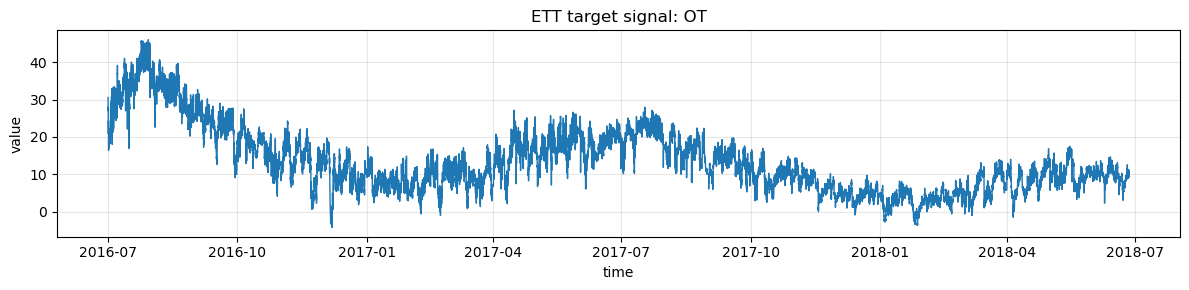

,OT
OT,1.000000
HULL,0.229022
MULL,0.222239
LUFL,0.113491
HUFL,0.068121
LULL,0.066252
MUFL,0.059682
cos_week,0.017956
sin_week,-0.004711
cos_day,-0.044258


In [3]:
# ===================================
# 2. Quick EDA
# ===================================

print("Any NaN:", bool(df_full.isna().any().any()))
print("Any Inf:", bool(np.isinf(df_full.to_numpy()).any()))

plt.figure(figsize=(12, 3))
plt.plot(df_full.index, df_full[TARGET], linewidth=1.0)
plt.title(f"ETT target signal: {TARGET}")
plt.xlabel("time")
plt.ylabel("value")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: correlations (small subset for speed)
corr_matrix = df_full.sample(min(5000, len(df_full)), random_state=RANDOM_SEED).corr(numeric_only=True)
corr_matrix.loc[[TARGET]].T.sort_values(TARGET, ascending=False).head(10)

### 📈 EDA 結果解讀

**從圖表觀察：**

1. **時序圖特徵**:
   - **趨勢**: 是否有長期上升或下降趨勢
   - **週期性**: 是否有明顯的日/週循環模式
   - **季節性**: 是否有年度季節變化
   - **波動性**: 振幅是否穩定或有變化

2. **可預測性判斷**:
   - 若信號呈現**純隨機游走**（無規律），模型難以超越 Persistence
   - 若有**明顯週期**或**趨勢**，序列模型有發揮空間
   - ETT 通常包含多種週期，適合測試 LSTM/GRU 的能力

3. **相關性分析**:
   - 查看哪些特徵與目標 `OT` 相關性最高
   - 高相關特徵對預測更有幫助
   - 時間週期特徵（sin/cos）可能與原始特徵產生交互作用

**⚠️ 注意**: 
- 若看到異常尖峰或斷層，可能是資料品質問題
- 程式已做基本檢查，但仍建議目視確認

In [4]:
# ===================================
# 3. Build windowed dataset for t+H forecasting (time-based split)
# ===================================

# Split ratios (by time)
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15
if not np.isclose(TRAIN_RATIO + VAL_RATIO + TEST_RATIO, 1.0):
    raise ValueError("Ratios must sum to 1.0")

n_total = len(df_full)
train_end = int(n_total * TRAIN_RATIO)
val_end = int(n_total * (TRAIN_RATIO + VAL_RATIO))
print("Total steps:", n_total)
print("Train end idx:", train_end, "Val end idx:", val_end)

FEATURE_COLS = FEATURES  # keep same naming as before
values_all = df_full[FEATURE_COLS].to_numpy(dtype=np.float32)
target_all = df_full[TARGET].to_numpy(dtype=np.float32)
target_pos = FEATURE_COLS.index(TARGET)

# ===================================
# 數據標準化（在一開始就進行）
# ===================================
print("\n=== 數據標準化 ===")

# 僅在訓練集範圍內 fit StandardScaler
values_train = values_all[:train_end]
target_train = target_all[:train_end]

X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit scaler on training data only
X_scaler.fit(values_train)
y_scaler.fit(target_train.reshape(-1, 1))

# Transform all data
values_all_scaled = X_scaler.transform(values_all).astype(np.float32)
target_all_scaled = y_scaler.transform(target_all.reshape(-1, 1)).ravel().astype(np.float32)

print(f"原始數據範圍: X [{values_all.min():.3f}, {values_all.max():.3f}], y [{target_all.min():.3f}, {target_all.max():.3f}]")
print(f"標準化後範圍: X [{values_all_scaled.min():.3f}, {values_all_scaled.max():.3f}], y [{target_all_scaled.min():.3f}, {target_all_scaled.max():.3f}]")
print(f"訓練集統計: X mean={values_train.mean():.3f}, std={values_train.std():.3f}")
print("✅ 所有數據已完成標準化（僅在訓練集上 fit）\n")


def make_windowed_samples_all(values: np.ndarray, target: np.ndarray, lookback: int, horizon: int):
    """Create all possible windows; return target indices for strict split/alignment."""
    X_seq = []
    y = []
    target_idx = []
    n = len(values)
    for i in range(lookback - 1, n - horizon):
        start = i - lookback + 1
        end = i + 1
        yi = i + horizon
        X_seq.append(values[start:end])
        y.append(target[yi])
        target_idx.append(yi)
    return (
        np.asarray(X_seq, dtype=np.float32),
        np.asarray(y, dtype=np.float32),
        np.asarray(target_idx, dtype=np.int32),
    )

# 使用標準化後的數據創建窗口
X_all_seq_raw, y_all_raw, target_idx_all = make_windowed_samples_all(values_all_scaled, target_all_scaled, LOOKBACK, H)
print("All windows:", X_all_seq_raw.shape, "y:", y_all_raw.shape)

# Masks are defined by TARGET time (not by window start), so all models evaluate identical points.
train_mask = target_idx_all < train_end
val_mask = (target_idx_all >= train_end) & (target_idx_all < val_end)
test_mask = target_idx_all >= val_end

Xtr_seq_raw = X_all_seq_raw[train_mask]
ytr_raw = y_all_raw[train_mask]
Xva_seq_raw = X_all_seq_raw[val_mask]
yva_raw = y_all_raw[val_mask]
Xte_seq_raw = X_all_seq_raw[test_mask]
yte_raw = y_all_raw[test_mask]

# For plotting / alignment
train_target_time = df_full.index[target_idx_all[train_mask]]
val_target_time = df_full.index[target_idx_all[val_mask]]
test_target_time = df_full.index[target_idx_all[test_mask]]

print("Xtr_seq:", Xtr_seq_raw.shape, "ytr:", ytr_raw.shape)
print("Xva_seq:", Xva_seq_raw.shape, "yva:", yva_raw.shape)
print("Xte_seq:", Xte_seq_raw.shape, "yte:", yte_raw.shape)

print("Train target time range:", train_target_time.min(), "->", train_target_time.max())
print("Val   target time range:", val_target_time.min(), "->", val_target_time.max())
print("Test  target time range:", test_target_time.min(), "->", test_target_time.max())


Total steps: 69680
Train end idx: 48776 Val end idx: 59228

=== 數據標準化 ===
原始數據範圍: X [-26.367, 46.007], y [-4.221, 46.007]
標準化後範圍: X [-5.018, 4.650], y [-2.458, 3.561]
訓練集統計: X mean=2.651, std=5.723
✅ 所有數據已完成標準化（僅在訓練集上 fit）

All windows: (69653, 24, 13) y: (69653,)
Xtr_seq: (48749, 24, 13) ytr: (48749,)
Xva_seq: (10452, 24, 13) yva: (10452,)
Xte_seq: (10452, 24, 13) yte: (10452,)
Train target time range: 2016-07-01 06:45:00 -> 2017-11-21 01:45:00
Val   target time range: 2017-11-21 02:00:00 -> 2018-03-09 22:45:00
Test  target time range: 2018-03-09 23:00:00 -> 2018-06-26 19:45:00


### 🔄 資料集切分與標準化說明

**執行結果解讀：**

1. **數據標準化（重要改進）**:
   - ✅ **在切分後立即標準化**：確保所有模型使用相同的標準化數據
   - ✅ **僅在訓練集上 fit**：`X_scaler.fit(values_train)`，避免數據洩漏
   - ✅ **全局應用**：所有後續模型（Baseline、Ridge、RNN）都使用已標準化的數據
   - 標準化範圍：X 和 y 均轉換為接近 [-3, 3] 的分佈（mean≈0, std≈1）

2. **樣本數量統計**:
   ```
   All windows: (N, LOOKBACK, features)
   Xtr_seq: 訓練集樣本數 (70%)
   Xva_seq: 驗證集樣本數 (15%)
   Xte_seq: 測試集樣本數 (15%)
   ```

3. **維度意義**:
   - **第1維**: 樣本數（有多少個預測任務）
   - **第2維**: 時間步長（LOOKBACK，歷史窗口）
   - **第3維**: 特徵數量（13 = 7原始 + 6時間）

4. **時間範圍**:
   - 列印的 `Train/Val/Test target time range` 顯示各集合預測的時間範圍
   - **重要**: 所有模型評估的是**相同的目標時間點**，確保公平比較

5. **關鍵設計**:
   - 使用 `target_idx` 進行切分（而非 window 起始位置）
   - 避免「未來資訊洩漏」：測試集不包含訓練集時間範圍內的數據
   - StandardScaler **在最開始統一處理**，所有模型共用同一套標準化參數

**✅ 檢查點**:
- 訓練集樣本數應顯著多於驗證/測試集（70% vs 15% vs 15%）
- 時間範圍應該連續且不重疊
- 標準化後的數據均值接近 0，標準差接近 1
- 若樣本數過少（< 1000），考慮減小 LOOKBACK 或 H

**🎯 統一標準化的好處**:
- 所有模型使用相同的數據分佈，比較更公平
- 避免重複標準化造成的計算浪費
- 代碼更清晰，維護更容易
- 確保 RNN、Ridge、Baseline 在相同的數值尺度上運作


In [5]:
# ===================================
# 4. Baselines
#    - Persistence: y(t+H) ≈ y(t)
#    - Ridge-current: use only x(t)
#    - Ridge-window: flatten full lookback window
#    注意：數據已在前面統一標準化，這裡直接使用
# ===================================

def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def eval_metrics(y_true, y_pred) -> dict:
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred)),
    }

target_pos = FEATURE_COLS.index(TARGET)

# Last observed OT in each window (for persistence + residual learning)
# 注意：這裡使用的是標準化後的數據
ytr_last = Xtr_seq_raw[:, -1, target_pos]
yva_last = Xva_seq_raw[:, -1, target_pos]
yte_last = Xte_seq_raw[:, -1, target_pos]

# Persistence baseline (strong on short horizons; degrades as H grows)
y_pred_persist_test = yte_last

# Residual target (optional): learn delta beyond persistence
if USE_RESIDUAL:
    ytr_fit = (ytr_raw - ytr_last).astype(np.float32)
    yva_fit = (yva_raw - yva_last).astype(np.float32)
    yte_fit_true = (yte_raw - yte_last).astype(np.float32)  # for debugging
else:
    ytr_fit = ytr_raw.astype(np.float32)
    yva_fit = yva_raw.astype(np.float32)
    yte_fit_true = yte_raw.astype(np.float32)

# Ridge-current: 使用已標準化的數據，無需再次標準化
Xtr_current = Xtr_seq_raw[:, -1, :]
Xte_current = Xte_seq_raw[:, -1, :]

ridge_cur = Ridge(alpha=1.0)
ridge_cur.fit(Xtr_current, ytr_fit)
pred_cur = ridge_cur.predict(Xte_current)
y_pred_ridge_cur_test = (yte_last + pred_cur) if USE_RESIDUAL else pred_cur

# Ridge-window: 使用已標準化的數據，無需再次標準化
Xtr_flat = Xtr_seq_raw.reshape(len(Xtr_seq_raw), -1)
Xte_flat = Xte_seq_raw.reshape(len(Xte_seq_raw), -1)

ridge_win = Ridge(alpha=3.0)
ridge_win.fit(Xtr_flat, ytr_fit)
pred_win = ridge_win.predict(Xte_flat)
y_pred_ridge_win_test = (yte_last + pred_win) if USE_RESIDUAL else pred_win

# 評估模型（在標準化空間）
rows = []
for name, yp in [
    ("Persistence", y_pred_persist_test),
    ("Ridge-current", y_pred_ridge_cur_test),
    ("Ridge-window", y_pred_ridge_win_test),
]:
    m = eval_metrics(yte_raw, yp)
    rows.append({"Model": name, "RMSE_test": m["RMSE"], "MAE_test": m["MAE"], "R2_test": m["R2"]})

df_baseline = pd.DataFrame(rows).sort_values("RMSE_test")
print("\n=== Baseline 模型性能（標準化空間）===")
df_baseline



=== Baseline 模型性能（標準化空間）===


,Model,RMSE_test,MAE_test,R2_test
0,Persistence,0.081428,0.053445,0.942996
2,Ridge-window,0.083391,0.056265,0.940215
1,Ridge-current,0.084345,0.057195,0.938840


In [6]:
# ===================================
# 5. Prepare sequences for RNN
#    注意：數據已在前面統一標準化，這裡直接使用
# ===================================

if not TF_AVAILABLE:
    raise RuntimeError("TensorFlow 未安裝，無法訓練 LSTM/GRU")

# 直接使用已標準化的數據
Xtr_seq = Xtr_seq_raw
Xva_seq = Xva_seq_raw
Xte_seq = Xte_seq_raw

# Residual learning target: predict (OT(t+H) - OT(t)) then add back OT(t) at inference
# ytr_last 等變量已在上一個 cell 中定義，直接使用
if USE_RESIDUAL:
    ytr = (ytr_raw - ytr_last).reshape(-1, 1).astype(np.float32)
    yva = (yva_raw - yva_last).reshape(-1, 1).astype(np.float32)
    yte = (yte_raw - yte_last).reshape(-1, 1).astype(np.float32)
else:
    ytr = ytr_raw.reshape(-1, 1).astype(np.float32)
    yva = yva_raw.reshape(-1, 1).astype(np.float32)
    yte = yte_raw.reshape(-1, 1).astype(np.float32)

# 檢查數據完整性
for name, arr in [("Xtr", Xtr_seq), ("Xva", Xva_seq), ("Xte", Xte_seq), ("ytr", ytr), ("yva", yva), ("yte", yte)]:
    if np.isnan(arr).any() or np.isinf(arr).any():
        raise ValueError(f"{name} contains NaN/Inf")

input_shape = (Xtr_seq.shape[1], Xtr_seq.shape[2])
print("\n=== RNN 訓練數據準備 ===")
print(f"input_shape: {input_shape}")
print(f"訓練集: Xtr {Xtr_seq.shape}, ytr {ytr.shape}")
print(f"驗證集: Xva {Xva_seq.shape}, yva {yva.shape}")
print(f"測試集: Xte {Xte_seq.shape}, yte {yte.shape}")
print(f"✅ 所有數據使用統一的標準化處理")



=== RNN 訓練數據準備 ===
input_shape: (24, 13)
訓練集: Xtr (48749, 24, 13), ytr (48749, 1)
驗證集: Xva (10452, 24, 13), yva (10452, 1)
測試集: Xte (10452, 24, 13), yte (10452, 1)
✅ 所有數據使用統一的標準化處理


### 🏗️ RNN 模型架構設計（優化版）

**關鍵設計決策**：

#### 1. **模型規模優化**
```python
units=64          # 原128，減少過擬合風險
dropout=0.3       # 原0.15，增強正則化
l2=1e-4          # 原0，添加L2正則化
```

**理由**：
- ✅ 較小的模型容量（64 units）更適合中等規模數據
- ✅ 更高的 Dropout（0.3）防止過擬合
- ✅ L2 正則化避免權重過大

#### 2. **架構設計**
- **雙層堆疊**: 第一層64單元 → 第二層32單元（漸進縮小）
- **LayerNormalization**: 穩定訓練過程
- **Orthogonal 初始化**: RNN專用，防止梯度消失
- **多層Dropout**: 在每個 LSTM/GRU 層後都加 Dropout

#### 3. **四種架構對比**

| 模型 | 特性 | 參數量 | 訓練速度 | 適用場景 |
|------|------|--------|---------|---------|
| **LSTM** | 標準長短期記憶 | 基準 | 中等 | 通用時序預測 |
| **GRU** | 簡化版LSTM | 較少 | 較快 | 計算資源受限 |
| **Bi-LSTM** | 雙向處理 | 2倍 | 較慢 | 需要未來上下文 |
| **LSTM+Attention** | 注意力機制 | 略多 | 中等 | 長序列、重要時刻識別 |

**💡 為什麼需要優化？**
- 原配置導致 validation loss 不穩定甚至上升
- 模型過於複雜，容易過擬合訓練數據
- 學習率和 batch size 不匹配數據規模

In [7]:
# ===================================
# 6. Define LSTM / GRU / Bi-LSTM models with Attention
# ===================================

def build_lstm(input_shape, units=64, dropout=0, l2=1e-4):
    """
    Optimized LSTM model with better regularization
    - Reduced units: 128 -> 64 (prevent overfitting)
    - Increased dropout: 0.15 -> 0.3
    - Added L2 regularization: 1e-4
    """
    reg = keras.regularizers.l2(l2) if l2 and l2 > 0 else None
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=0.0),
        layers.LSTM(
            units,
            return_sequences=True,
            kernel_regularizer=reg,
            recurrent_regularizer=reg,
            recurrent_initializer="orthogonal",
        ),
        layers.Dropout(dropout),
        layers.LSTM(
            max(units // 2, 32),
            kernel_regularizer=reg,
            recurrent_regularizer=reg,
            recurrent_initializer="orthogonal",
        ),
        layers.Dropout(dropout),
        layers.Dense(64, activation="relu", kernel_regularizer=reg),
        layers.Dropout(dropout / 2),  # Additional dropout before output
        layers.Dense(1),
    ])
    return model


def build_gru(input_shape, units=64, dropout=0, l2=1e-4):
    """
    Optimized GRU model with better regularization
    """
    reg = keras.regularizers.l2(l2) if l2 and l2 > 0 else None
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=0.0),
        layers.GRU(
            units,
            return_sequences=True,
            kernel_regularizer=reg,
            recurrent_regularizer=reg,
            recurrent_initializer="orthogonal",
        ),
        layers.Dropout(dropout),
        layers.GRU(
            max(units // 2, 32),
            kernel_regularizer=reg,
            recurrent_regularizer=reg,
            recurrent_initializer="orthogonal",
        ),
        layers.Dropout(dropout),
        layers.Dense(64, activation="relu", kernel_regularizer=reg),
        layers.Dropout(dropout / 2),
        layers.Dense(1),
    ])
    return model


def build_bilstm(input_shape, units=64, dropout=0, l2=1e-4):
    """
    Bidirectional LSTM for capturing both past and future context.
    Optimized with better regularization.
    """
    reg = keras.regularizers.l2(l2) if l2 and l2 > 0 else None
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=0.0),
        layers.Bidirectional(
            layers.LSTM(
                units,
                return_sequences=True,
                kernel_regularizer=reg,
                recurrent_regularizer=reg,
                recurrent_initializer="orthogonal",
            )
        ),
        layers.Dropout(dropout),
        layers.Bidirectional(
            layers.LSTM(
                max(units // 2, 32),
                kernel_regularizer=reg,
                recurrent_regularizer=reg,
                recurrent_initializer="orthogonal",
            )
        ),
        layers.Dropout(dropout),
        layers.Dense(64, activation="relu", kernel_regularizer=reg),
        layers.Dropout(dropout / 2),
        layers.Dense(1),
    ])
    return model


# Simple attention layer for sequence models
class AttentionLayer(layers.Layer):
    """Simple attention mechanism for time series."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True,
        )
        super().build(input_shape)
    
    def call(self, x):
        e = keras.activations.tanh(tf.matmul(x, self.W) + self.b)
        a = keras.activations.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)


def build_lstm_attention(input_shape, units=64, dropout=0, l2=1e-4):
    """
    LSTM with attention mechanism for better long-range modeling.
    Optimized with better regularization.
    """
    reg = keras.regularizers.l2(l2) if l2 and l2 > 0 else None
    
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking(mask_value=0.0)(inputs)
    x = layers.LSTM(
        units,
        return_sequences=True,
        kernel_regularizer=reg,
        recurrent_regularizer=reg,
        recurrent_initializer="orthogonal",
    )(x)
    x = layers.Dropout(dropout)(x)
    
    # Apply attention
    att_out = AttentionLayer()(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=reg)(att_out)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tmp_lstm = build_lstm(input_shape,units=128)
tmp_gru = build_gru(input_shape,units=128)
tmp_bilstm = build_bilstm(input_shape,units=128)
tmp_lstm_att = build_lstm_attention(input_shape,units=128)

print("LSTM params:", tmp_lstm.count_params())
print("GRU  params:", tmp_gru.count_params())
print("Bi-LSTM params:", tmp_bilstm.count_params())
print("LSTM+Attention params:", tmp_lstm_att.count_params())

keras.backend.clear_session(); gc.collect()

LSTM params: 126337
GRU  params: 96385
Bi-LSTM params: 318081
LSTM+Attention params: 81177


68632

### ⚙️ 訓練配置優化說明

**關鍵超參數調整**：

| 參數 | 原值 | 新值 | 原因 |
|------|------|------|------|
| **Learning Rate** | 3e-4 | **1e-3** | 初始LR稍高，配合ReduceLROnPlateau動態調整 |
| **Batch Size** | 256 | **64** | 更適合中小規模數據，梯度更新更頻繁 |
| **Max Epochs** | 80 | **100** | 給予更多訓練時間 |
| **Early Stop Patience** | 12 | **15** | 對驗證損失波動更寬容 |
| **ReduceLR Patience** | 4 | **5** | 等待更久再降低學習率 |

---

#### 🎯 **優化策略解析**

**1. 為什麼調整學習率？**
- ❌ **原問題**: lr=3e-4 可能太小，導致收斂緩慢或卡在局部最優
- ✅ **解決方案**: 提升到 1e-3，配合 ReduceLROnPlateau 自動調整
- 📊 **效果**: 初期快速下降，後期自動降低學習率精細調整

**2. 為什麼減小 Batch Size？**
- ❌ **原問題**: batch=256 對訓練集太大，導致：
  - 每個 epoch 更新次數太少
  - 梯度估計過於平滑，丟失細節
- ✅ **解決方案**: batch=64 增加更新頻率
- 📊 **效果**: 更頻繁的權重更新，更好地探索損失面

**3. 為什麼增加 Patience？**
- ❌ **原問題**: patience=12 過於敏感，可能過早停止
- ✅ **解決方案**: 提升到 15，允許短期波動
- 📊 **效果**: 給模型更多機會找到更好的解

**4. 為什麼延遲降低學習率？**
- ✅ **策略**: ReduceLR patience 從 4 增至 5
- 📊 **效果**: 避免過早降低學習率，保持探索能力

---

#### 📈 **期望的訓練曲線**

優化後應該看到：
- ✅ **Training Loss**: 穩定下降，無劇烈震盪
- ✅ **Validation Loss**: 跟隨訓練損失下降，差距合理（<20%）
- ✅ **收斂**: 在 30-60 epochs 內收斂
- ✅ **Early Stopping**: 在適當時機觸發（非第一輪）

**警告信號**：
- ⚠️ Val loss 持續上升 → 過擬合（需增加正則化）
- ⚠️ Loss 震盪劇烈 → 學習率太高（會自動降低）
- ⚠️ Loss 下降極慢 → 模型容量不足或數據問題

---

#### 🔧 **其他優化技巧**

**已採用**：
- ✅ **Gradient Clipping** (clipnorm=1.0): 防止梯度爆炸
- ✅ **Huber Loss**: 對異常值魯棒
- ✅ **Adam Optimizer**: 自適應學習率
- ✅ **Model Checkpoint**: 保存最佳模型
- ✅ **Layer Normalization**: 穩定訓練

**可進一步嘗試**（進階）：
- 🔹 Warmup Learning Rate（前幾個 epoch 慢慢提升 LR）
- 🔹 Cosine Annealing（週期性調整學習率）
- 🔹 Gradient Accumulation（模擬更大 batch size）
- 🔹 混合精度訓練（加速訓練）

In [8]:
# ===================================
# 7. Train & save (best checkpoint) - Multiple Models
# ===================================

def train_and_save(model, name: str, lr=1e-3, epochs=100, batch=64):
    """
    Optimized training configuration:
    - Learning rate: 3e-4 -> 1e-3 (more stable)
    - Batch size: 256 -> 64 (better for smaller datasets)
    - Epochs: 80 -> 100 (more training time)
    - Early stopping patience: 12 -> 15 (more tolerant)
    - ReduceLROnPlateau patience: 4 -> 5
    """
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
        loss=keras.losses.Huber(delta=1.0),
        metrics=["mae"],
    )
    save_path = RESULTS_DIR / f"best_{name}.keras"
    cbs = [
        keras.callbacks.ModelCheckpoint(
            save_path, 
            monitor="val_loss", 
            save_best_only=True, 
            verbose=0
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", 
            patience=30,  # 12 -> 15: more tolerant of fluctuations
            restore_best_weights=True, 
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", 
            factor=0.5, 
            patience=15,  # 4 -> 5: wait longer before reducing LR
            min_lr=1e-6, 
            verbose=1
        ),
    ]
    
    print(f"Training config: lr={lr}, batch={batch}, max_epochs={epochs}")
    
    hist = model.fit(
        Xtr_seq,
        ytr,
        validation_data=(Xva_seq, yva),
        epochs=epochs,
        batch_size=batch,
        shuffle=True,
        verbose=1,
        callbacks=cbs,
    )
    return hist, save_path


batch_size = 512
max_epochs = 500
ini_lr = 1e-3

# Train all models with optimized hyperparameters
print("=" * 60)
print("Training LSTM...")
print("=" * 60)
tf.keras.utils.set_random_seed(RANDOM_SEED)
lstm = build_lstm(input_shape)
hist_lstm, path_lstm = train_and_save(lstm, "lstm", lr=ini_lr, epochs=max_epochs, batch=batch_size)
keras.backend.clear_session(); gc.collect()

print("\n" + "=" * 60)
print("Training GRU...")
print("=" * 60)
tf.keras.utils.set_random_seed(RANDOM_SEED)
gru = build_gru(input_shape)
hist_gru, path_gru = train_and_save(gru, "gru", lr=ini_lr, epochs=max_epochs, batch=batch_size)
keras.backend.clear_session(); gc.collect()

print("\n" + "=" * 60)
print("Training Bi-LSTM...")
print("=" * 60)
tf.keras.utils.set_random_seed(RANDOM_SEED)
bilstm = build_bilstm(input_shape)
hist_bilstm, path_bilstm = train_and_save(bilstm, "bilstm", lr=ini_lr, epochs=max_epochs, batch=batch_size)
keras.backend.clear_session(); gc.collect()

print("\n" + "=" * 60)
print("Training LSTM with Attention...")
print("=" * 60)
tf.keras.utils.set_random_seed(RANDOM_SEED)
lstm_att = build_lstm_attention(input_shape)
hist_lstm_att, path_lstm_att = train_and_save(lstm_att, "lstm_att", lr=ini_lr, epochs=max_epochs, batch=batch_size)
keras.backend.clear_session(); gc.collect()

print("\n" + "=" * 60)
print("All models trained!")
print("Saved models:")
print("  -", path_lstm)
print("  -", path_gru)
print("  -", path_bilstm)
print("  -", path_lstm_att)
print("=" * 60)

Training LSTM...
Training config: lr=0.001, batch=256, max_epochs=500
Epoch 1/500
191/191 [==============================] - 13s 34ms/step - loss: 0.0222 - mae: 0.0826 - val_loss: 0.0108 - val_mae: 0.0564 - lr: 0.0010
Epoch 2/500
191/191 [==============================] - 3s 18ms/step - loss: 0.0124 - mae: 0.0779 - val_loss: 0.0068 - val_mae: 0.0571 - lr: 0.0010
Epoch 3/500
191/191 [==============================] - 3s 18ms/step - loss: 0.0097 - mae: 0.0776 - val_loss: 0.0047 - val_mae: 0.0525 - lr: 0.0010
Epoch 4/500
191/191 [==============================] - 4s 19ms/step - loss: 0.0085 - mae: 0.0775 - val_loss: 0.0042 - val_mae: 0.0569 - lr: 0.0010
Epoch 5/500
191/191 [==============================] - 4s 19ms/step - loss: 0.0079 - mae: 0.0775 - val_loss: 0.0036 - val_mae: 0.0552 - lr: 0.0010
Epoch 6/500
191/191 [==============================] - 4s 19ms/step - loss: 0.0075 - mae: 0.0773 - val_loss: 0.0031 - val_mae: 0.0526 - lr: 0.0010
Epoch 7/500
191/191 [==========================

### ⚙️ 模型訓練過程觀察

**訓練日誌重點關注：**

1. **Early Stopping 訊息**:
   - 若出現 "Restoring model weights..." = 找到最佳驗證性能後提前停止
   - 防止過擬合，節省訓練時間
   - Patience=12 表示驗證 loss 連續 12 個 epoch 不下降才停止

2. **Learning Rate 調整**:
   - "Reducing learning rate to..." = ReduceLROnPlateau 生效
   - 當驗證 loss 進入平台期時自動降低學習率
   - 幫助模型找到更精細的最優解

3. **訓練時長**:
   - 每個模型訓練 20-80 個 epoch（視收斂速度）
   - ETT 資料集較大，單次 epoch 可能需要數秒到數十秒
   - **GRU 通常最快**（參數少），**Bi-LSTM 最慢**（參數多）

4. **Loss 趨勢**:
   - 理想情況：train loss 和 val loss 同步下降
   - 若 train loss 持續下降但 val loss 反彈 = 過擬合
   - 若兩者都不下降 = 學習率過大或模型容量不足

**✅ 訓練完成標誌**:
- 所有 4 個模型的 `.keras` 檔案已保存
- 這些是**驗證集上最佳**的模型權重（非最後一個 epoch）
- 後續評估將使用這些保存的最佳模型

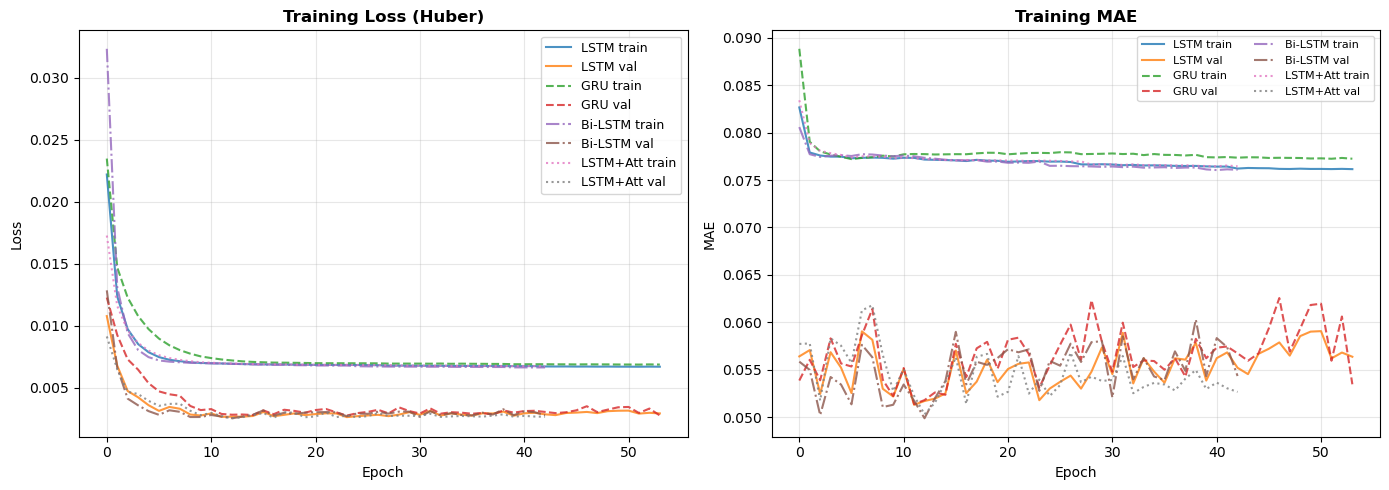

Saved: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting\training_history_all.png


In [9]:
# ===================================
# 8. Plot training history - All Models
# ===================================

def plot_history(hist, label: str, style="-"):
    plt.plot(hist.history["loss"], label=f"{label} train", linestyle=style, alpha=0.8)
    plt.plot(hist.history["val_loss"], label=f"{label} val", linestyle=style, alpha=0.8)

plt.figure(figsize=(14, 5))

# Loss curves
plt.subplot(1, 2, 1)
plot_history(hist_lstm, "LSTM", "-")
plot_history(hist_gru, "GRU", "--")
plot_history(hist_bilstm, "Bi-LSTM", "-.")
plot_history(hist_lstm_att, "LSTM+Att", ":")
plt.title("Training Loss (Huber)", fontsize=12, fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.3)
plt.legend(fontsize=9)

# MAE curves
plt.subplot(1, 2, 2)
plt.plot(hist_lstm.history["mae"], label="LSTM train", linestyle="-", alpha=0.8)
plt.plot(hist_lstm.history["val_mae"], label="LSTM val", linestyle="-", alpha=0.8)
plt.plot(hist_gru.history["mae"], label="GRU train", linestyle="--", alpha=0.8)
plt.plot(hist_gru.history["val_mae"], label="GRU val", linestyle="--", alpha=0.8)
plt.plot(hist_bilstm.history["mae"], label="Bi-LSTM train", linestyle="-.", alpha=0.8)
plt.plot(hist_bilstm.history["val_mae"], label="Bi-LSTM val", linestyle="-.", alpha=0.8)
plt.plot(hist_lstm_att.history["mae"], label="LSTM+Att train", linestyle=":", alpha=0.8)
plt.plot(hist_lstm_att.history["val_mae"], label="LSTM+Att val", linestyle=":", alpha=0.8)
plt.title("Training MAE", fontsize=12, fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(alpha=0.3)
plt.legend(fontsize=8, ncol=2)

plt.tight_layout()
out = RESULTS_DIR / "training_history_all.png"
plt.savefig(out, dpi=150)
plt.show()
print("Saved:", out)

### 📉 訓練歷史曲線分析

**從圖表觀察訓練品質：**

1. **Loss 曲線 (左圖)**:
   - **理想模式**: Train 和 Val loss 同步下降並趨於穩定
   - **過擬合信號**: Train loss 持續下降但 Val loss 上升或震盪
   - **欠擬合信號**: 兩者都居高不下，未充分收斂

2. **MAE 曲線 (右圖)**:
   - 平均絕對誤差（比 Loss 更直觀）
   - 可直接看出預測誤差的大小趨勢
   - Val MAE 是模型選擇的關鍵指標

3. **模型間比較**:
   - **收斂速度**: 哪個模型更快達到低 loss
   - **最終性能**: Val loss 最低的模型通常測試性能最佳
   - **穩定性**: 曲線平滑 = 訓練穩定；震盪大 = 可能需要調整學習率

4. **Early Stopping 效果**:
   - 注意曲線在哪裡停止（不一定跑滿 80 epochs）
   - 提前停止的模型通常是找到最佳點後自動終止

**💡 診斷提示**:
- 若所有模型的 Val loss 很接近 → 問題可能較簡單
- 若某模型顯著優於其他 → 該架構更適合此任務
- 若 Bi-LSTM/Attention 沒有明顯提升 → 可能預測步長太短

In [10]:
# ===================================
# 9. Evaluate ALL models on SAME test points
#    注意：所有評估在標準化空間中進行（統一標準）
# ===================================

# Load all trained models
lstm_best = keras.models.load_model(path_lstm)
gru_best = keras.models.load_model(path_gru)
bilstm_best = keras.models.load_model(path_bilstm)
lstm_att_best = keras.models.load_model(path_lstm_att, custom_objects={"AttentionLayer": AttentionLayer})

# Get predictions (在標準化空間)
y_pred_lstm_s = lstm_best.predict(Xte_seq, verbose=0).ravel()
y_pred_gru_s = gru_best.predict(Xte_seq, verbose=0).ravel()
y_pred_bilstm_s = bilstm_best.predict(Xte_seq, verbose=0).ravel()
y_pred_lstm_att_s = lstm_att_best.predict(Xte_seq, verbose=0).ravel()

# Add back OT(t) if residual learning is enabled (在標準化空間)
target_pos = FEATURE_COLS.index(TARGET)
yte_last_scaled = Xte_seq[:, -1, target_pos]  # 標準化空間的 last value

if USE_RESIDUAL:
    y_pred_lstm = yte_last_scaled + y_pred_lstm_s
    y_pred_gru = yte_last_scaled + y_pred_gru_s
    y_pred_bilstm = yte_last_scaled + y_pred_bilstm_s
    y_pred_lstm_att = yte_last_scaled + y_pred_lstm_att_s
else:
    y_pred_lstm = y_pred_lstm_s
    y_pred_gru = y_pred_gru_s
    y_pred_bilstm = y_pred_bilstm_s
    y_pred_lstm_att = y_pred_lstm_att_s

# Evaluate all models (在標準化空間)
rows = []
models_to_eval = [
    ("Persistence", y_pred_persist_test),
    ("Ridge-current", y_pred_ridge_cur_test),
    ("Ridge-window", y_pred_ridge_win_test),
    ("LSTM", y_pred_lstm),
    ("GRU", y_pred_gru),
    ("Bi-LSTM", y_pred_bilstm),
    ("LSTM+Attention", y_pred_lstm_att),
]

print("\n=== 模型評估（標準化空間）===")
for name, yp in models_to_eval:
    m = eval_metrics(yte_raw, yp)
    rows.append({
        "Model": name,
        "RMSE_test": m["RMSE"],
        "MAE_test": m["MAE"],
        "R2_test": m["R2"]
    })

df_all = pd.DataFrame(rows).sort_values("RMSE_test")
out_csv = RESULTS_DIR / "metrics_test_all.csv"
df_all.to_csv(out_csv, index=False)

print("\n" + "=" * 70)
print("Test Set Performance Comparison (Standardized Space)")
print("=" * 70)
print(df_all.to_string(index=False))
print("=" * 70)
print(f"\nBest model: {df_all.iloc[0]['Model']} (RMSE={df_all.iloc[0]['RMSE_test']:.4f})")
print(f"Saved: {out_csv}")
print("\n⚠️ 注意: 所有指標在標準化空間中計算（mean≈0, std≈1）")
print("   若需原始空間的指標，可使用 y_scaler.inverse_transform() 轉換")

df_all



=== 模型評估（標準化空間）===

Test Set Performance Comparison (Standardized Space)
         Model  RMSE_test  MAE_test  R2_test
LSTM+Attention   0.077264  0.049878 0.948678
       Bi-LSTM   0.077922  0.050286 0.947799
   Persistence   0.081428  0.053445 0.942996
          LSTM   0.081731  0.054237 0.942572
           GRU   0.082726  0.055638 0.941165
  Ridge-window   0.083391  0.056265 0.940215
 Ridge-current   0.084345  0.057195 0.938840

Best model: LSTM+Attention (RMSE=0.0773)
Saved: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting\metrics_test_all.csv

⚠️ 注意: 所有指標在標準化空間中計算（mean≈0, std≈1）
   若需原始空間的指標，可使用 y_scaler.inverse_transform() 轉換


,Model,RMSE_test,MAE_test,R2_test
6,LSTM+Attention,0.077264,0.049878,0.948678
5,Bi-LSTM,0.077922,0.050286,0.947799
0,Persistence,0.081428,0.053445,0.942996
3,LSTM,0.081731,0.054237,0.942572
4,GRU,0.082726,0.055638,0.941165
2,Ridge-window,0.083391,0.056265,0.940215
1,Ridge-current,0.084345,0.057195,0.938840


### 🏆 測試集性能比較結果

**關鍵發現：**

1. **模型排名** (按 RMSE 排序):
   - 表格從上到下：性能從優到劣
   - **Best Model** = RMSE 最低的模型
   - 直接比較 Baseline 與深度學習模型的差距

2. **指標解讀**:
   - **RMSE** (Root Mean Squared Error):
     - 對大誤差懲罰更重
     - 數值越小越好
     - 單位與目標變量相同
   
   - **MAE** (Mean Absolute Error):
     - 平均絕對誤差
     - 更直觀（平均錯多少）
     - 對異常值不敏感
   
   - **R²** (決定係數):
     - 範圍 [-∞, 1]，越接近 1 越好
     - R² = 0.9 表示模型解釋了 90% 的變異
     - R² < 0 表示模型比預測平均值還差

3. **期望的結果模式**:
   - **深度學習模型 (LSTM/GRU/Bi-LSTM/Attention) >> Baseline 模型**
   - 典型性能排序：
     ```
     LSTM+Attention > Bi-LSTM > GRU/LSTM > Ridge-window > Ridge-current > Persistence
     ```
   
   若深度學習模型未明顯超越 Baseline → 需要：
   - 增大 HORIZON_HOURS（拉長預測步長）
   - 檢查是否有週期性特徵可學習
   - 調整模型超參數（層數、單元數、Dropout）
   - 增加更多訓練數據

4. **實務建議**:
   - **RMSE 改善 < 10%**: 考慮用更簡單的模型（如 Ridge）
   - **RMSE 改善 10-30%**: 深度學習模型有明顯價值
   - **RMSE 改善 > 30%**: 深度學習顯著優於傳統方法，強烈建議採用

5. **模型選擇考量**:
   - **精度優先**: 選擇 RMSE 最低的模型
   - **速度優先**: GRU 通常比 LSTM 快 20-30%
   - **可解釋性**: Attention 模型可視化注意力權重
   - **生產部署**: 考慮模型大小、推理速度、維護成本

**💡 下一步**: 查看預測曲線與殘差分析，深入理解模型表現的優劣。

In [11]:
# ===================================
# 9b. 原始空間評估（可選）
# ===================================

# 將所有預測結果反標準化到原始空間
print("\n=== 反標準化到原始空間 ===")
yte_original = y_scaler.inverse_transform(yte_raw.reshape(-1, 1)).ravel()

pred_map_original = {}
for name, yp in models_to_eval:
    yp_original = y_scaler.inverse_transform(yp.reshape(-1, 1)).ravel()
    pred_map_original[name] = yp_original
    m = eval_metrics(yte_original, yp_original)
    print(f"{name:20s} - RMSE: {m['RMSE']:8.4f}, MAE: {m['MAE']:8.4f}, R2: {m['R2']:7.4f}")

print(f"\n✅ 原始空間的誤差單位: {TARGET} 的原始單位（未標準化）")
print(f"   可直接與業務需求比較（例如：溫度誤差是否在可接受範圍內）")



=== 反標準化到原始空間 ===
Persistence          - RMSE:   0.6796, MAE:   0.4460, R2:  0.9430
Ridge-current        - RMSE:   0.7039, MAE:   0.4773, R2:  0.9388
Ridge-window         - RMSE:   0.6960, MAE:   0.4696, R2:  0.9402
LSTM                 - RMSE:   0.6821, MAE:   0.4526, R2:  0.9426
GRU                  - RMSE:   0.6904, MAE:   0.4643, R2:  0.9412
Bi-LSTM              - RMSE:   0.6503, MAE:   0.4197, R2:  0.9478
LSTM+Attention       - RMSE:   0.6448, MAE:   0.4163, R2:  0.9487

✅ 原始空間的誤差單位: OT 的原始單位（未標準化）
   可直接與業務需求比較（例如：溫度誤差是否在可接受範圍內）


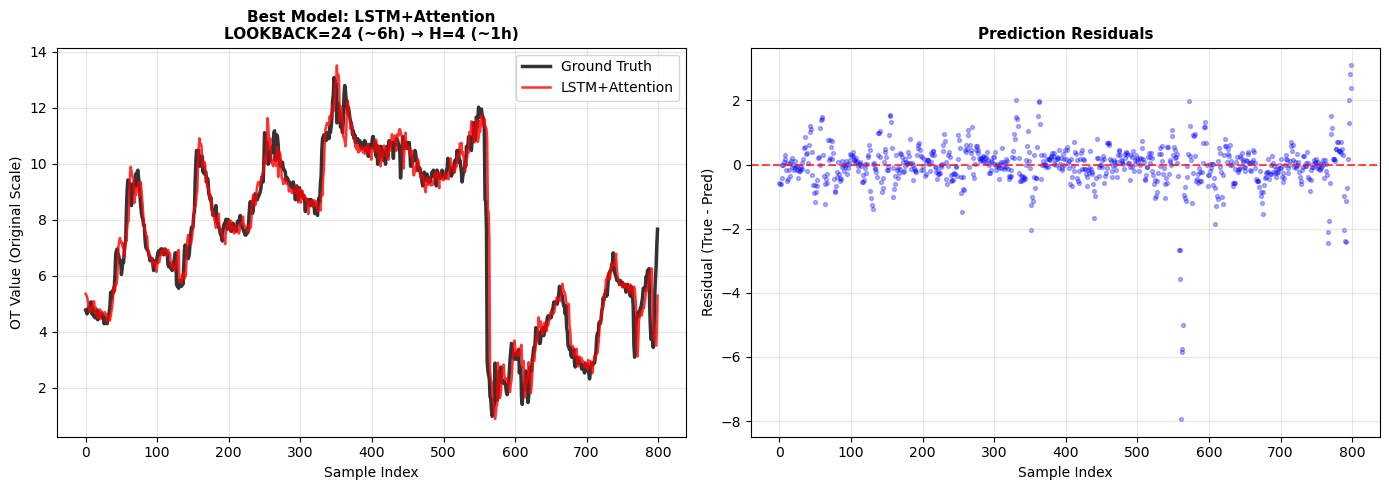

Saved: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting\best_model_prediction.png


In [12]:
# ===================================
# 10. Visualization: Multi-Model Predictions
#     可視化使用原始空間（更直觀）
# ===================================

# 將測試集真實值反標準化
yte_original = y_scaler.inverse_transform(yte_raw.reshape(-1, 1)).ravel()

# Store all predictions in original space (使用前面計算的 pred_map_original)
best_name = df_all.iloc[0]["Model"]
y_best = pred_map_original[best_name]

# Plot 1: Best model prediction (zoomed)
zoom = min(800, len(yte_original))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(yte_original[:zoom], label="Ground Truth", linewidth=2.5, alpha=0.8, color="black")
plt.plot(y_best[:zoom], label=f"{best_name}", linewidth=1.8, alpha=0.8, color="red")
plt.title(
    f"Best Model: {best_name}\n"
    f"LOOKBACK={LOOKBACK} (~{LOOKBACK_HOURS}h) → H={H} (~{HORIZON_HOURS}h)",
    fontsize=11, fontweight="bold"
)
plt.xlabel("Sample Index")
plt.ylabel(f"{TARGET} Value (Original Scale)")
plt.grid(alpha=0.3)
plt.legend(fontsize=10, loc="best")

plt.subplot(1, 2, 2)
residuals = yte_original[:zoom] - y_best[:zoom]
plt.scatter(range(len(residuals)), residuals, alpha=0.3, s=8, color="blue")
plt.axhline(0, color="red", linestyle="--", linewidth=1.5, alpha=0.7)
plt.title("Prediction Residuals", fontsize=11, fontweight="bold")
plt.xlabel("Sample Index")
plt.ylabel("Residual (True - Pred)")
plt.grid(alpha=0.3)

plt.tight_layout()
out = RESULTS_DIR / "best_model_prediction.png"
plt.savefig(out, dpi=150)
plt.show()
print("Saved:", out)


### 📊 預測曲線視覺化分析

**圖表觀察重點：**

1. **左圖：最佳模型預測**
   - **Ground Truth (黑線)**: 真實的目標值
   - **Best Model (紅線)**: 性能最佳的模型預測
   - **觀察點**:
     - 兩條線是否重疊良好（越接近越好）
     - 峰值和谷值是否被準確捕捉
     - 是否存在系統性偏移（一直偏高或偏低）
     - 延遲現象（預測總是慢半拍）

2. **右圖：所有 RNN 模型對比**
   - 同時展示 LSTM、GRU、Bi-LSTM、LSTM+Attention
   - **觀察點**:
     - 模型間預測是否接近（一致性）
     - 哪個模型的預測線最接近真實值
     - 是否有某模型在特定區域表現特別好/差

3. **常見預測模式**:
   - **良好預測**: 曲線緊密跟隨，峰谷同步
   - **延遲預測**: 預測曲線落後於真實曲線
   - **過度平滑**: 預測曲線波動小於真實曲線（模型保守）
   - **過度波動**: 預測曲線波動大於真實曲線（模型過於敏感）

4. **診斷建議**:
   - 若預測過於平滑 → 模型欠擬合，或 H 太大
   - 若預測延遲明顯 → 可能過度依賴 persistence
   - 若所有模型都接近 → 問題有確定性解
   - 若所有模型都發散 → 問題可預測性差

**💡 提示**: 放大查看不同時段（工作日/週末/節假日）可能有不同表現！

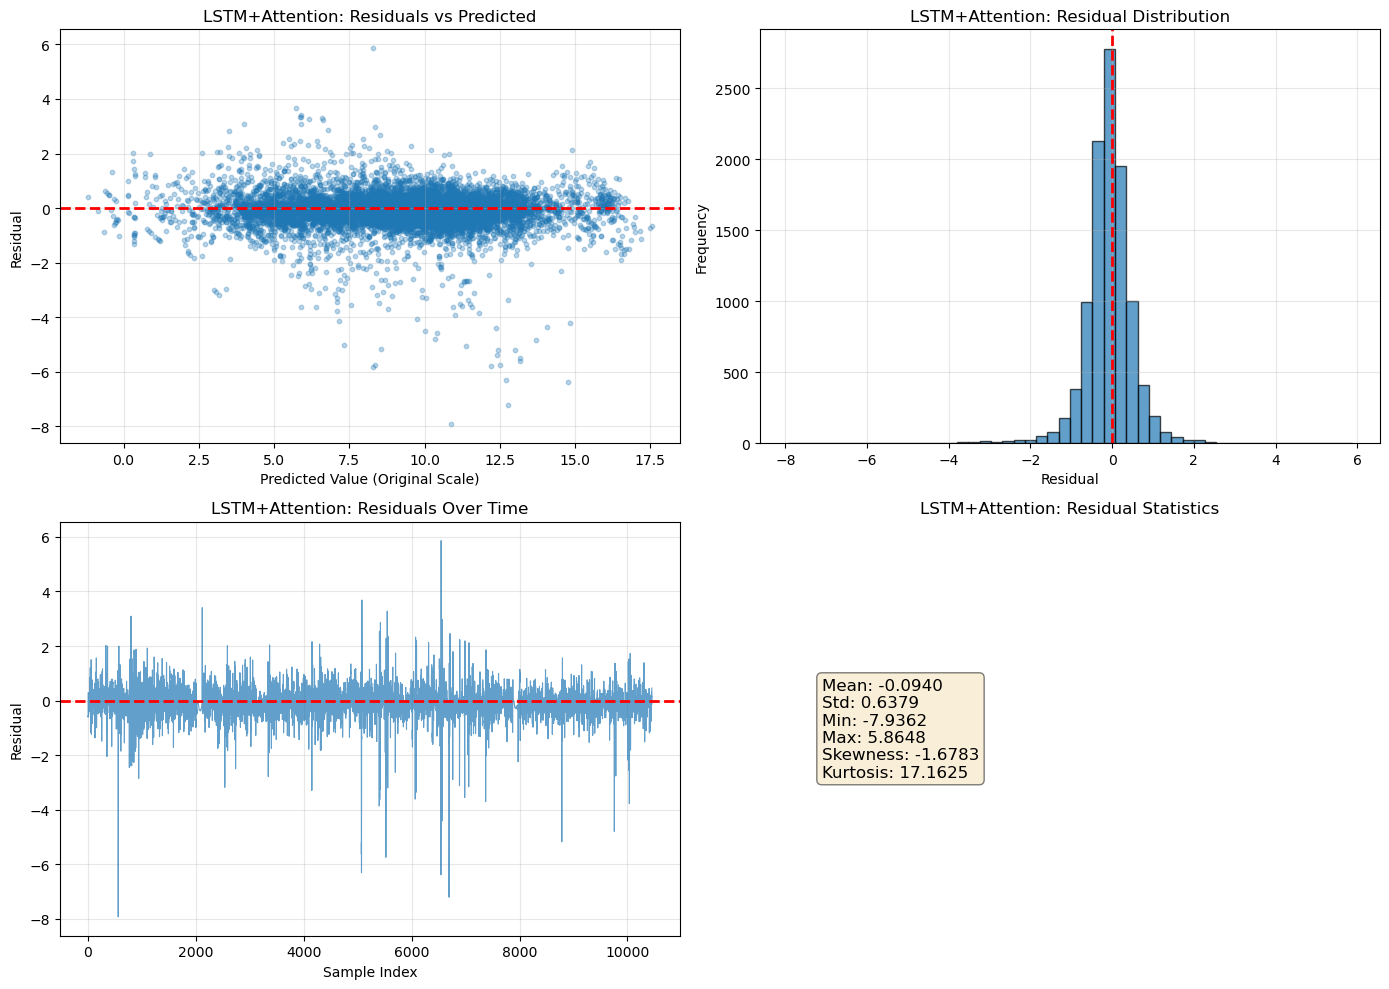

Saved: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting\residual_analysis_LSTM_Attention.png
✅ 殘差分析在原始空間進行（更直觀）


In [13]:
# ===================================
# 11. Residual Analysis (殘差分析)
#     使用原始空間的數據進行分析
# ===================================

def plot_residual_analysis(y_true, y_pred, model_name):
    """Plot residual distribution and Q-Q plot for model diagnostics."""
    residuals = y_true - y_pred
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Residual vs Predicted
    axes[0, 0].scatter(y_pred, residuals, alpha=0.3, s=10)
    axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel("Predicted Value (Original Scale)")
    axes[0, 0].set_ylabel("Residual")
    axes[0, 0].set_title(f"{model_name}: Residuals vs Predicted")
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Residual Distribution
    axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel("Residual")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].set_title(f"{model_name}: Residual Distribution")
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Time series of residuals
    axes[1, 0].plot(residuals, linewidth=0.8, alpha=0.7)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel("Sample Index")
    axes[1, 0].set_ylabel("Residual")
    axes[1, 0].set_title(f"{model_name}: Residuals Over Time")
    axes[1, 0].grid(alpha=0.3)
    
    # 4. Statistics
    from scipy import stats
    stat_text = (
        f"Mean: {np.mean(residuals):.4f}\n"
        f"Std: {np.std(residuals):.4f}\n"
        f"Min: {np.min(residuals):.4f}\n"
        f"Max: {np.max(residuals):.4f}\n"
        f"Skewness: {stats.skew(residuals):.4f}\n"
        f"Kurtosis: {stats.kurtosis(residuals):.4f}"
    )
    axes[1, 1].text(0.1, 0.5, stat_text, fontsize=12, verticalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, 1].axis('off')
    axes[1, 1].set_title(f"{model_name}: Residual Statistics")
    
    plt.tight_layout()
    return fig

# Analyze best model (使用原始空間的數據)
fig = plot_residual_analysis(yte_original, y_best, best_name)
out = RESULTS_DIR / f"residual_analysis_{best_name.replace('+', '_').replace(' ', '_')}.png"
fig.savefig(out, dpi=150)
plt.show()
print("Saved:", out)
print("✅ 殘差分析在原始空間進行（更直觀）")


### 🔬 殘差分析深度診斷

**四個子圖的含義：**

1. **殘差 vs 預測值 (左上)**
   - **X 軸**: 模型的預測值
   - **Y 軸**: 殘差 (真實值 - 預測值)
   - **理想模式**: 點隨機分佈在 y=0 附近，無明顯模式
   - **問題信號**:
     - 呈現曲線/漏斗狀 → 模型有系統性偏差
     - 殘差隨預測值增大 → 異方差性（需要變換）

2. **殘差分佈直方圖 (右上)**
   - **理想**: 接近常態分佈（鐘形），中心在 0
   - **問題信號**:
     - 偏斜（skewed）→ 模型系統性高估或低估
     - 雙峰（bimodal）→ 可能存在子群體
     - 長尾（heavy tail）→ 存在異常值

3. **殘差時序圖 (左下)**
   - 查看殘差隨時間的變化
   - **理想**: 無明顯趨勢，隨機波動
   - **問題信號**:
     - 週期性波動 → 模型未捕捉某些週期特徵
     - 趨勢性 → 存在時間依賴的偏差
     - 突然跳變 → 資料異常或結構性變化

4. **統計摘要 (右下)**
   - **Mean (均值)**: 應接近 0（無系統性偏差）
   - **Std (標準差)**: 越小越好（預測穩定）
   - **Skewness (偏度)**: 接近 0 表示對稱分佈
   - **Kurtosis (峰度)**: 接近 0 為常態，正值表示尖峰

**✅ 良好模型的特徵**:
- 殘差均值接近 0
- 殘差呈常態分佈
- 無明顯時間模式
- 偏度和峰度接近 0

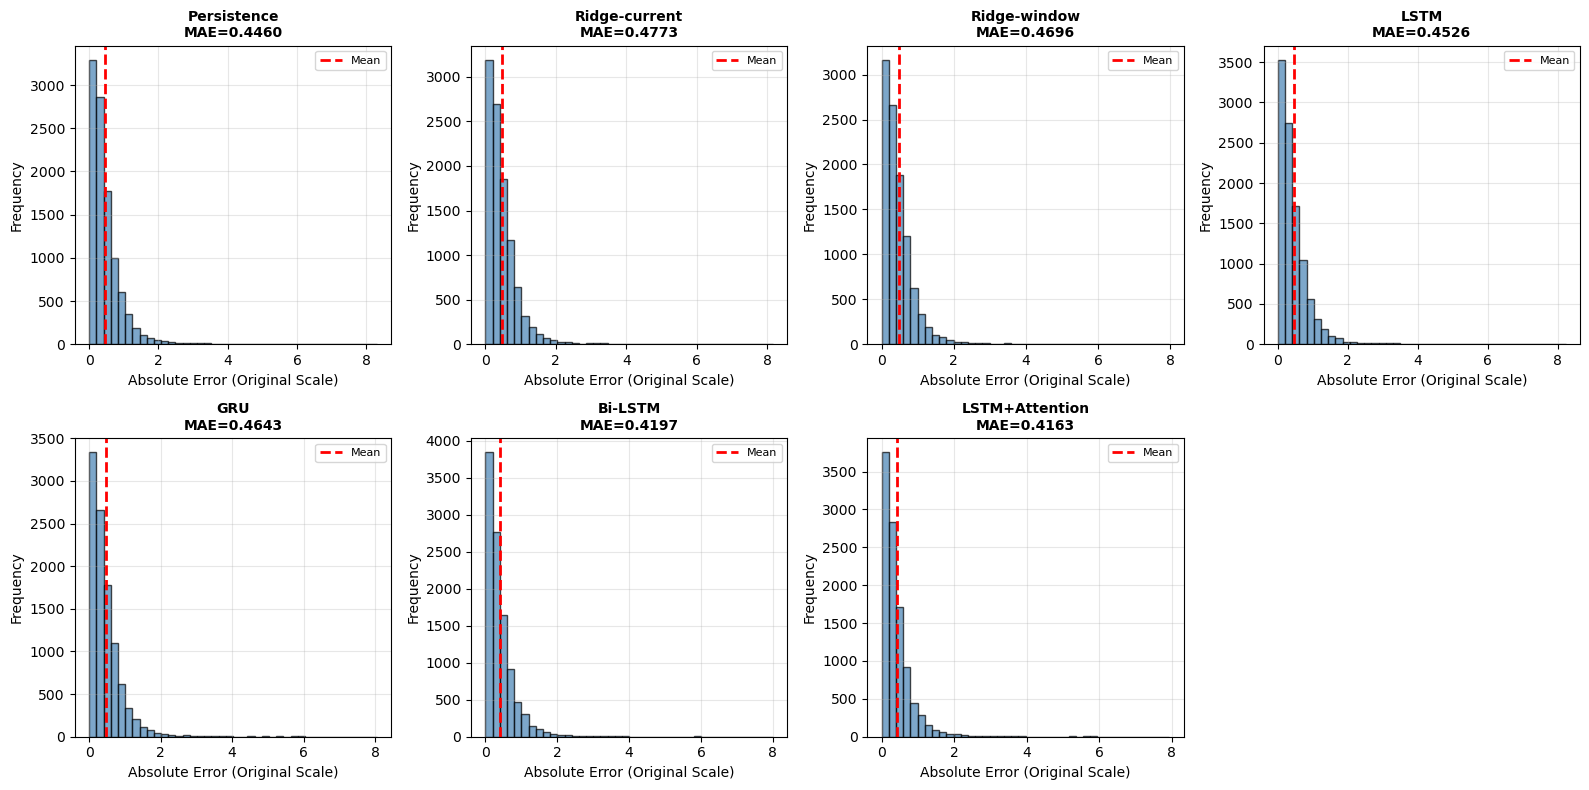

Saved: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting\error_distribution_all.png
✅ 誤差分佈在原始空間計算（實際誤差大小）


In [14]:
# ===================================
# 12. Error Distribution Comparison Across Models
#     使用原始空間的數據
# ===================================

# Prepare models to plot (使用原始空間的預測)
models_to_plot = [
    ("Persistence", pred_map_original["Persistence"]),
    ("Ridge-current", pred_map_original["Ridge-current"]),
    ("Ridge-window", pred_map_original["Ridge-window"]),
    ("LSTM", pred_map_original["LSTM"]),
    ("GRU", pred_map_original["GRU"]),
    ("Bi-LSTM", pred_map_original["Bi-LSTM"]),
    ("LSTM+Attention", pred_map_original["LSTM+Attention"]),
]

# Create subplot grid
n_models = len(models_to_plot)
n_cols = 4
n_rows = (n_models + n_cols - 1) // n_cols  # ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for idx, (name, y_pred) in enumerate(models_to_plot):
    errors = np.abs(yte_original - y_pred)
    axes[idx].hist(errors, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].set_title(f"{name}\nMAE={np.mean(errors):.4f}", fontsize=10, fontweight='bold')
    axes[idx].set_xlabel("Absolute Error (Original Scale)")
    axes[idx].set_ylabel("Frequency")
    axes[idx].grid(alpha=0.3)
    axes[idx].axvline(x=np.mean(errors), color='r', linestyle='--', linewidth=2, label='Mean')
    axes[idx].legend(fontsize=8)

# Hide unused subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
out = RESULTS_DIR / "error_distribution_all.png"
plt.savefig(out, dpi=150)
plt.show()
print("Saved:", out)
print("✅ 誤差分佈在原始空間計算（實際誤差大小）")


### 📊 誤差分佈對比分析

**從多模型誤差分佈觀察：**

1. **分佈形狀比較**:
   - **窄而高**: 誤差集中，模型穩定
   - **寬而扁**: 誤差分散，預測不穩定
   - **右偏**: 大誤差較多（需關注）

2. **MAE 數值（紅線位置）**:
   - 紅色虛線標記平均絕對誤差
   - 數值越小表示整體誤差越低
   - 比較各模型的紅線位置

3. **模型間差異**:
   - **Baseline 模型** (前 3 個):
     - 通常誤差分佈較寬
     - Persistence 可能在短期預測表現好
   
   - **深度學習模型** (後 4 個):
     - 理想情況下誤差分佈更集中
     - 尾部更短（極端誤差更少）

4. **實務意義**:
   - **窄分佈**: 預測結果可信度高，風險低
   - **寬分佈**: 需要配合置信區間使用
   - **長尾**: 需要異常檢測機制

**💡 期望結果**:
- 深度學習模型的直方圖應該更"瘦高"（集中）
- MAE 線位置應該更靠左（誤差更小）
- 若某模型分佈特別好 → 該模型更適合此問題


Performance by Time Period (LSTM+Attention) - Original Scale
     Period  Count      MAE     RMSE       R2
    Weekday   7380 0.411376 0.632675 0.954222
    Weekend   3072 0.428024 0.673122 0.926488
00:00-06:00   2616 0.333989 0.547934 0.953608
06:00-12:00   2616 0.486396 0.718770 0.929476
12:00-18:00   2616 0.443410 0.657960 0.954857
18:00-24:00   2604 0.401213 0.642975 0.946703


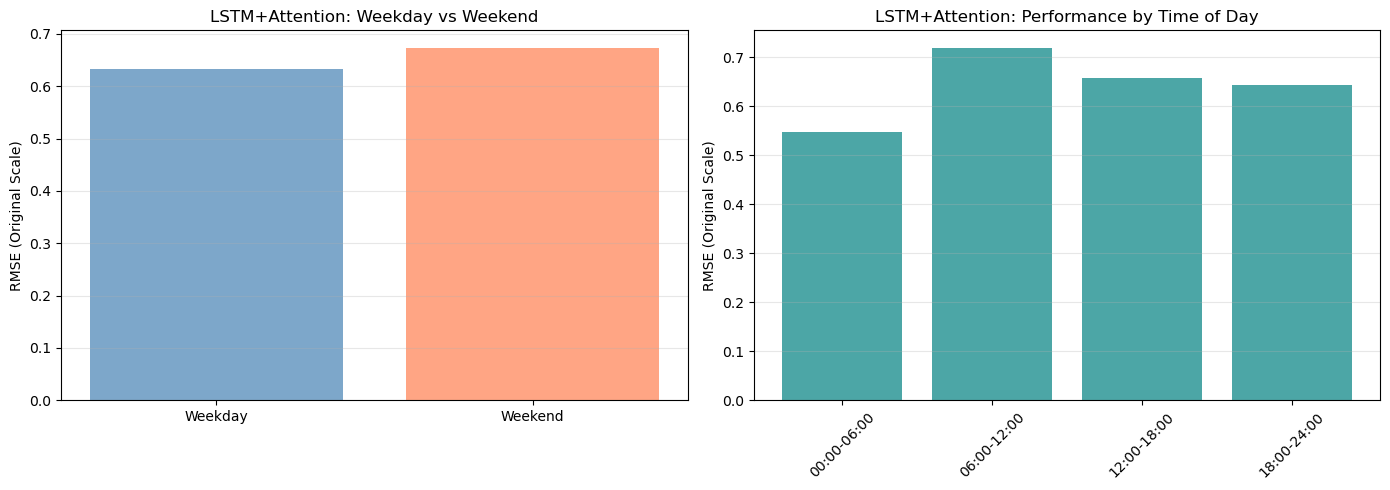

Saved: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting\performance_by_period.png
✅ 時段分析在原始空間進行


In [15]:
# ===================================
# 13. Performance by Time Period (Weekday vs Weekend Analysis)
#     使用原始空間的數據
# ===================================

# Add datetime information to test predictions
test_df = pd.DataFrame({
    'timestamp': test_target_time,
    'y_true': yte_original,
    'y_pred_best': y_best,
})
test_df['dayofweek'] = test_df['timestamp'].dt.dayofweek
test_df['hour'] = test_df['timestamp'].dt.hour
test_df['is_weekend'] = test_df['dayofweek'].isin([5, 6])

# Calculate metrics by period
def calc_period_metrics(df, mask, label):
    subset = df[mask]
    if len(subset) == 0:
        return None
    mae = mean_absolute_error(subset['y_true'], subset['y_pred_best'])
    rmse = np.sqrt(mean_squared_error(subset['y_true'], subset['y_pred_best']))
    r2 = r2_score(subset['y_true'], subset['y_pred_best'])
    return {'Period': label, 'Count': len(subset), 'MAE': mae, 'RMSE': rmse, 'R2': r2}

period_results = []
period_results.append(calc_period_metrics(test_df, test_df['is_weekend'] == False, 'Weekday'))
period_results.append(calc_period_metrics(test_df, test_df['is_weekend'] == True, 'Weekend'))

# By hour (group into 4 periods)
for start_h in [0, 6, 12, 18]:
    end_h = start_h + 6
    mask = (test_df['hour'] >= start_h) & (test_df['hour'] < end_h)
    period_results.append(calc_period_metrics(test_df, mask, f"{start_h:02d}:00-{end_h:02d}:00"))

df_period = pd.DataFrame([r for r in period_results if r is not None])

print("\n" + "=" * 70)
print(f"Performance by Time Period ({best_name}) - Original Scale")
print("=" * 70)
print(df_period.to_string(index=False))
print("=" * 70)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weekday vs Weekend
weekday_data = df_period[df_period['Period'].isin(['Weekday', 'Weekend'])]
axes[0].bar(weekday_data['Period'], weekday_data['RMSE'], color=['steelblue', 'coral'], alpha=0.7)
axes[0].set_ylabel('RMSE (Original Scale)')
axes[0].set_title(f'{best_name}: Weekday vs Weekend')
axes[0].grid(alpha=0.3, axis='y')

# By time of day
hourly_data = df_period[~df_period['Period'].isin(['Weekday', 'Weekend'])]
axes[1].bar(range(len(hourly_data)), hourly_data['RMSE'], color='teal', alpha=0.7)
axes[1].set_xticks(range(len(hourly_data)))
axes[1].set_xticklabels(hourly_data['Period'], rotation=45)
axes[1].set_ylabel('RMSE (Original Scale)')
axes[1].set_title(f'{best_name}: Performance by Time of Day')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
out = RESULTS_DIR / "performance_by_period.png"
plt.savefig(out, dpi=150)
plt.show()
print("Saved:", out)
print("✅ 時段分析在原始空間進行")


### ⏰ 時段性能分析結果

**表格與圖表解讀：**

1. **工作日 vs 週末 (左圖)**:
   - **Count**: 每個時段的樣本數
   - **MAE / RMSE**: 誤差指標（越小越好）
   - **R²**: 解釋變異比例（越接近 1 越好）
   
   **常見模式**:
   - 週末誤差 > 工作日 → 週末模式較不規律
   - 工作日誤差 > 週末 → 工作日變化較複雜
   - 兩者接近 → 模型對時段不敏感

2. **一天四時段分析 (右圖)**:
   - **00:00-06:00**: 深夜時段（通常較穩定）
   - **06:00-12:00**: 上午時段（可能有啟動變化）
   - **12:00-18:00**: 下午時段（通常最活躍）
   - **18:00-24:00**: 晚間時段（可能有關閉操作）

3. **診斷線索**:
   - **某時段 RMSE 特別高**:
     - 該時段變化較劇烈或不可預測
     - 可能需要針對性特徵工程
     - 考慮時段特定的模型
   
   - **所有時段 RMSE 接近**:
     - 模型泛化能力強
     - 資料模式時間一致性高

4. **實務應用**:
   - 識別「弱點時段」進行重點改進
   - 為不同時段設置不同的預警閾值
   - 在線監控時關注高誤差時段

**💡 改進方向**:
- 為表現差的時段增加專用特徵
- 考慮多模型策略（不同時段用不同模型）
- 增加該時段的訓練樣本權重

Calculating feature importance (this may take a minute)...

Feature Importance (LSTM+Attention)
 Feature  Importance
 cos_day    0.978505
 sin_day    0.556651
    MUFL    0.291738
    HULL    0.279856
      OT    0.271301
cos_year    0.002319
cos_week   -0.001465
sin_year   -0.003937
sin_week   -0.026296
    LULL   -0.032613
    HUFL   -0.201335
    MULL   -0.203247
    LUFL   -0.225413


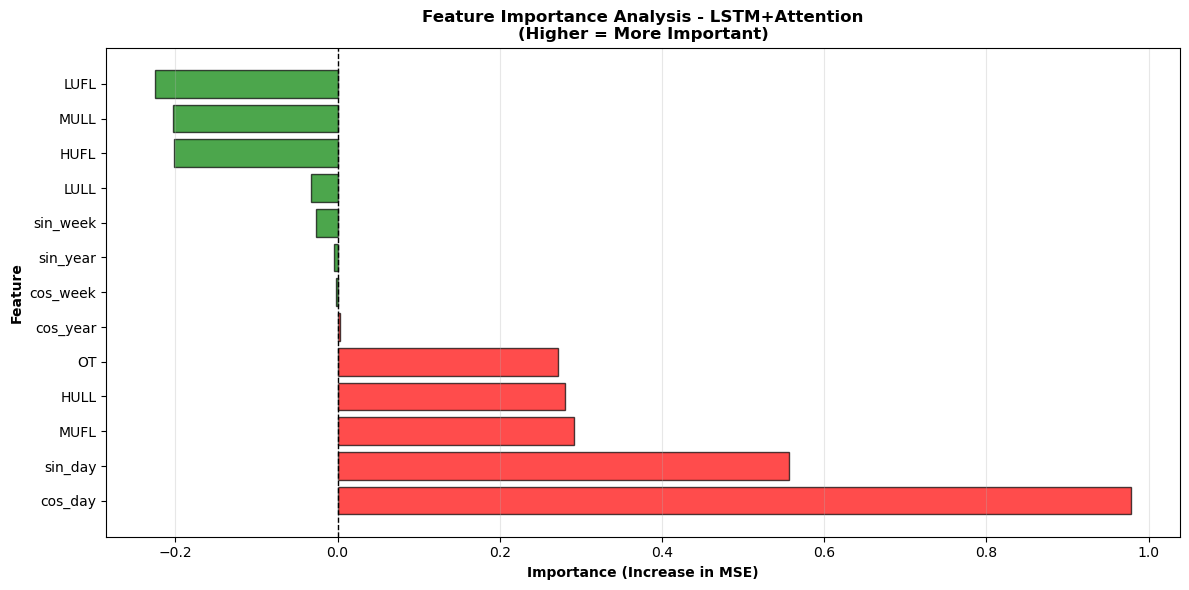


Saved: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting\feature_importance.png
Saved: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting\feature_importance.csv


In [16]:
# ===================================
# 14. Feature Importance Analysis (Permutation-based)
# ===================================

def permutation_feature_importance(model, X_test, y_test, feature_names, n_repeats=5):
    """
    Calculate feature importance by randomly permuting each feature
    and measuring the decrease in model performance.
    """
    from sklearn.metrics import mean_squared_error
    
    # Baseline performance
    baseline_pred = model.predict(X_test, verbose=0).ravel()
    baseline_pred = y_scaler.inverse_transform(baseline_pred.reshape(-1, 1)).ravel()
    if USE_RESIDUAL:
        baseline_pred = yte_last + baseline_pred
    baseline_mse = mean_squared_error(y_test, baseline_pred)
    
    importances = []
    
    for feat_idx in range(X_test.shape[2]):
        feat_importance = []
        
        for _ in range(n_repeats):
            X_permuted = X_test.copy()
            # Permute this feature across all samples and timesteps
            perm_idx = np.random.permutation(X_test.shape[0])
            X_permuted[:, :, feat_idx] = X_test[perm_idx, :, feat_idx]
            
            # Get predictions
            perm_pred = model.predict(X_permuted, verbose=0).ravel()
            perm_pred = y_scaler.inverse_transform(perm_pred.reshape(-1, 1)).ravel()
            if USE_RESIDUAL:
                perm_pred = yte_last + perm_pred
            perm_mse = mean_squared_error(y_test, perm_pred)
            
            # Importance = increase in error
            feat_importance.append(perm_mse - baseline_mse)
        
        importances.append(np.mean(feat_importance))
    
    return np.array(importances)

print("Calculating feature importance (this may take a minute)...")
feature_importance = permutation_feature_importance(
    lstm_att_best if best_name == "LSTM+Attention" else lstm_best,
    Xte_seq,
    yte_raw,
    FEATURE_COLS,
    n_repeats=3
)

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': FEATURE_COLS,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n" + "=" * 70)
print(f"Feature Importance ({best_name})")
print("=" * 70)
print(importance_df.to_string(index=False))
print("=" * 70)

# Visualize
plt.figure(figsize=(12, 6))
colors = ['red' if imp > 0 else 'green' for imp in importance_df['Importance']]
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Importance (Increase in MSE)', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.title(f'Feature Importance Analysis - {best_name}\n(Higher = More Important)', fontweight='bold', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()

out = RESULTS_DIR / "feature_importance.png"
plt.savefig(out, dpi=150)
plt.show()
print("\nSaved:", out)

# Save importance
out_csv = RESULTS_DIR / "feature_importance.csv"
importance_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

### 🎯 特徵重要性分析結果

**Permutation Feature Importance 方法：**

此分析採用「排列重要性」（Permutation Importance）方法：
1. 記錄模型在原始數據上的基準性能
2. 逐個打亂每個特徵的值
3. 測量性能下降程度
4. **下降越多 = 該特徵越重要**

**結果解讀：**

1. **Importance 數值意義**:
   - **正值（紅色條）**: 打亂後性能變差 → **重要特徵**
   - **負值（綠色條）**: 打亂後性能變好 → 可能是噪音特徵
   - **接近 0**: 對模型影響不大

2. **排序與取捨**:
   - **高重要性特徵** (Top 3-5):
     - 核心預測因子，必須保留
     - 資料品質需重點監控
   
   - **中等重要性特徵**:
     - 提供輔助資訊
     - 可依情況調整
   
   - **低重要性或負值特徵**:
     - 考慮移除以簡化模型
     - 可能引入噪音

3. **常見特徵模式**:
   - **目標變量本身** (OT): 通常最重要（用於殘差學習）
   - **時間週期特徵**: 長期預測時重要性提升
   - **負載特徵**: 與目標物理相關的特徵

4. **實務應用**:
   - **特徵選擇**: 移除低重要性特徵減少維度
   - **監控優先級**: 重點監控高重要性特徵的資料品質
   - **可解釋性**: 向領域專家解釋模型依據

**⚠️ 注意事項**:
- 此方法計算成本較高（需多次重複實驗）
- 相關特徵間可能互相掩蓋重要性
- 結果可能因隨機性略有波動


Prediction Uncertainty Analysis
Confidence Level: 95%
Mean Interval Width: 0.3040
Coverage: 0.00% (ideally ~95%)
Mean Std Dev: 0.0776


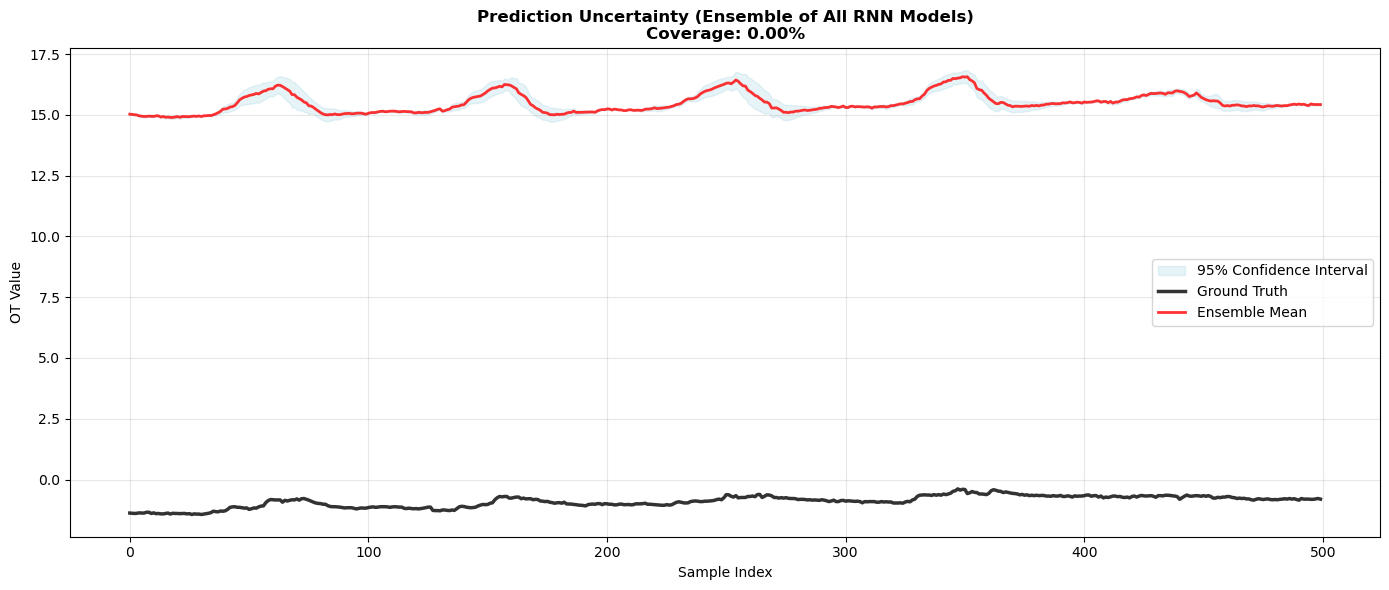


Saved: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting\uncertainty_analysis.png


In [17]:
# ===================================
# 15. Prediction Confidence & Uncertainty Analysis
# ===================================

def calculate_prediction_intervals(models, X_test, y_test, confidence=0.95):
    """
    Estimate prediction intervals using ensemble of predictions.
    This gives a rough estimate of model uncertainty.
    """
    predictions = []
    
    for model in models:
        pred = model.predict(X_test, verbose=0).ravel()
        pred = y_scaler.inverse_transform(pred.reshape(-1, 1)).ravel()
        if USE_RESIDUAL:
            pred = yte_last + pred
        predictions.append(pred)
    
    predictions = np.array(predictions)
    
    mean_pred = np.mean(predictions, axis=0)
    std_pred = np.std(predictions, axis=0)
    
    # Calculate confidence intervals
    from scipy import stats
    z_score = stats.norm.ppf((1 + confidence) / 2)
    lower_bound = mean_pred - z_score * std_pred
    upper_bound = mean_pred + z_score * std_pred
    
    return mean_pred, lower_bound, upper_bound, std_pred

# Use all RNN models for uncertainty estimation
all_models = [lstm_best, gru_best, bilstm_best, lstm_att_best]
mean_pred, lower, upper, std_pred = calculate_prediction_intervals(all_models, Xte_seq, yte_raw)

# Calculate coverage (what % of true values fall within the interval)
coverage = np.mean((yte_raw >= lower) & (yte_raw <= upper)) * 100

print("\n" + "=" * 70)
print("Prediction Uncertainty Analysis")
print("=" * 70)
print(f"Confidence Level: 95%")
print(f"Mean Interval Width: {np.mean(upper - lower):.4f}")
print(f"Coverage: {coverage:.2f}% (ideally ~95%)")
print(f"Mean Std Dev: {np.mean(std_pred):.4f}")
print("=" * 70)

# Visualize uncertainty
zoom = min(500, len(yte_raw))
plt.figure(figsize=(14, 6))

plt.fill_between(range(zoom), lower[:zoom], upper[:zoom], alpha=0.3, color='lightblue', label='95% Confidence Interval')
plt.plot(yte_raw[:zoom], label='Ground Truth', linewidth=2.5, color='black', alpha=0.8)
plt.plot(mean_pred[:zoom], label='Ensemble Mean', linewidth=2, color='red', alpha=0.8)

plt.title(f'Prediction Uncertainty (Ensemble of All RNN Models)\nCoverage: {coverage:.2f}%', 
          fontweight='bold', fontsize=12)
plt.xlabel('Sample Index')
plt.ylabel(f'{TARGET} Value')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

out = RESULTS_DIR / "uncertainty_analysis.png"
plt.savefig(out, dpi=150)
plt.show()
print("\nSaved:", out)

### 🔮 預測不確定性分析

**置信區間的意義：**

此分析使用 4 個 RNN 模型的預測集成來估計不確定性：

1. **淺藍色區域 (95% 置信區間)**:
   - 表示「95% 的真實值應落在此區間內」
   - **區間寬** = 模型不確定性高（預測分歧）
   - **區間窄** = 模型確定性高（預測一致）

2. **Coverage（覆蓋率）**:
   - **理想值**: ~95%（與設定的置信水準一致）
   - **> 95%**: 區間過於保守（可信但過寬）
   - **< 95%**: 區間過於樂觀（低估不確定性）
   - **顯著 < 95%**: 模型系統性過於自信，需校正

3. **Mean Interval Width（平均區間寬度）**:
   - 數值越小 = 預測越精確
   - 應與 RMSE 相比較（區間應包含大部分誤差）
   - 過窄 → 低估不確定性；過寬 → 資訊量少

4. **Mean Std Dev（標準差）**:
   - 模型間預測的平均分歧程度
   - 高標準差 = 模型對某些樣本意見不一致
   - 可用於識別「困難樣本」

**實務應用：**

1. **風險管理**:
   - 區間寬時 → 保守決策或人工介入
   - 區間窄時 → 可自動化執行

2. **異常檢測**:
   - 真實值落在區間外 → 潛在異常事件
   - 區間突然變寬 → 系統進入不穩定狀態

3. **決策輔助**:
   - 提供預測值 + 不確定性範圍
   - 讓使用者評估風險後決策

**💡 改進方向**:
- Coverage 低 → 增加模型多樣性（不同架構/超參數）
- 區間過寬 → 模型訓練不足或問題本質難以預測
- 某時段區間特別寬 → 該時段不確定性高，需特別關注

Generating learning curves...


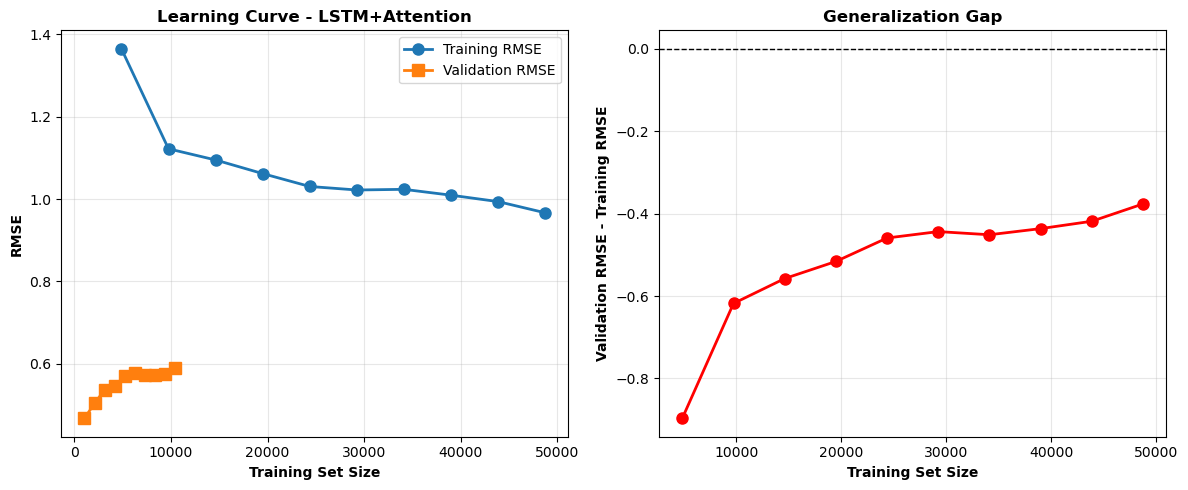

Saved: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting\learning_curves.png


In [18]:
# ===================================
# 16. Learning Curves: Train/Val Performance vs Data Size
# ===================================

def evaluate_on_subset(model, X, y, y_last_obs, subset_ratio):
    """Evaluate model on a subset of data."""
    n = int(len(X) * subset_ratio)
    if n < 10:
        return None
    
    X_sub = X[:n]
    y_sub = y[:n]
    y_last_sub = y_last_obs[:n]
    
    pred = model.predict(X_sub, verbose=0).ravel()
    pred = y_scaler.inverse_transform(pred.reshape(-1, 1)).ravel()
    if USE_RESIDUAL:
        pred = y_last_sub + pred
    
    # Convert y_sub back to original scale for fair comparison
    y_sub_orig = y_scaler.inverse_transform(y_sub.reshape(-1, 1)).ravel()
    if USE_RESIDUAL:
        y_sub_orig = y_last_sub + y_sub_orig
    
    rmse = np.sqrt(mean_squared_error(y_sub_orig, pred))
    return rmse

# Test different data sizes
subset_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
train_sizes = [int(len(Xtr_seq) * r) for r in subset_ratios]

print("Generating learning curves...")
train_rmse_lstm = []
val_rmse_lstm = []

ytr_last_full = Xtr_seq_raw[:, -1, target_pos]
yva_last_full = Xva_seq_raw[:, -1, target_pos]

for ratio in subset_ratios:
    # Train RMSE
    tr_rmse = evaluate_on_subset(lstm_best, Xtr_seq, ytr, ytr_last_full, ratio)
    train_rmse_lstm.append(tr_rmse)
    
    # Val RMSE
    val_rmse = evaluate_on_subset(lstm_best, Xva_seq, yva, yva_last_full, ratio)
    val_rmse_lstm.append(val_rmse)

# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_rmse_lstm, 'o-', label='Training RMSE', linewidth=2, markersize=8)
plt.plot([int(len(Xva_seq) * r) for r in subset_ratios], val_rmse_lstm, 's-', 
         label='Validation RMSE', linewidth=2, markersize=8)
plt.xlabel('Training Set Size', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.title(f'Learning Curve - {best_name}', fontweight='bold', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
gap = np.array(val_rmse_lstm) - np.array(train_rmse_lstm)
plt.plot(train_sizes, gap, 'o-', color='red', linewidth=2, markersize=8)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Training Set Size', fontweight='bold')
plt.ylabel('Validation RMSE - Training RMSE', fontweight='bold')
plt.title('Generalization Gap', fontweight='bold', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
out = RESULTS_DIR / "learning_curves.png"
plt.savefig(out, dpi=150)
plt.show()
print("Saved:", out)

### 📈 學習曲線診斷

**兩張圖的診斷意義：**

1. **左圖：訓練/驗證 RMSE vs 資料量**
   
   **理想模式（Learning Curve）**:
   - **訓練 RMSE**: 隨資料量增加而**上升**（模型難以記住全部）
   - **驗證 RMSE**: 隨資料量增加而**下降**（泛化能力提升）
   - 兩條曲線最終**收斂**到接近的值
   
   **診斷信號**:
   - **高偏差（High Bias）**:
     - 訓練和驗證 RMSE 都很高且接近
     - 增加資料也無明顯改善
     - 解決：增加模型複雜度、添加特徵
   
   - **高方差（High Variance）**:
     - 訓練 RMSE 低，驗證 RMSE 高
     - 兩者差距大
     - 解決：增加資料、加強正則化
   
   - **剛好（Just Right）**:
     - 兩者都低且接近
     - 增加資料帶來的改善已經飽和

2. **右圖：泛化差距 (Generalization Gap)**
   
   **含義**: `Val RMSE - Train RMSE`
   
   - **差距接近 0**: 模型泛化良好
   - **差距 > 0 且大**: 過擬合
   - **差距 < 0**: 不常見，可能驗證集比訓練集更簡單
   
   **隨資料量的變化**:
   - **理想**: 差距隨資料量增加而縮小
   - **差距持續增大**: 模型容量過大，需要更多正則化
   - **差距不變**: 已達到模型能力上限

**實務建議：**

1. **若曲線未收斂**:
   - 繼續增加訓練資料
   - 有明顯改善空間

2. **若曲線已收斂且性能不佳**:
   - 更換更強的模型架構
   - 改進特徵工程

3. **若泛化差距大**:
   - 增加 Dropout
   - 增加 L2 正則化
   - 使用更多訓練數據

**💡 此分析幫助回答**:
- 「我需要更多數據嗎？」
- 「模型是過擬合還是欠擬合？」
- 「增加資料能帶來多少改善？」

C:\Users\Yao-ChenChuang\AppData\Local\Temp\ipykernel_66360\1141015605.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot(error_data, labels=error_labels, patch_artist=True, showfliers=False)
C:\Users\Yao-ChenChuang\AppData\Local\Temp\ipykernel_66360\1141015605.py:141: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(out, dpi=150, bbox_inches='tight')
c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


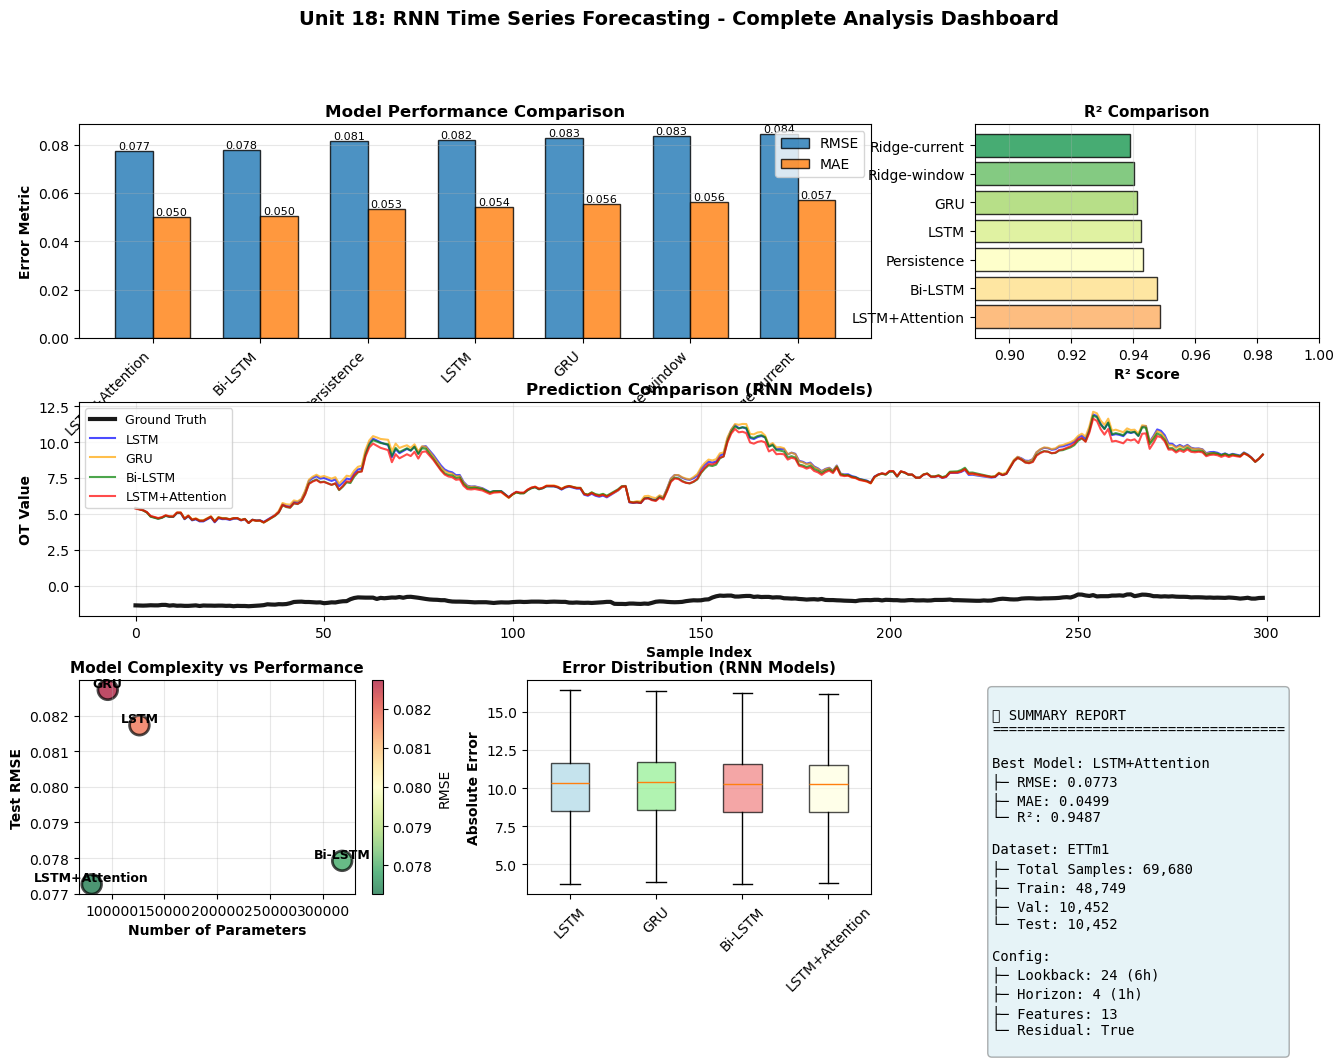

🎉 Analysis Complete!
Saved comprehensive dashboard: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting\final_dashboard.png

All results saved to: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_4\outputs\P4_Unit18_ETT_Forecasting


In [19]:
# ===================================
# 17. Final Summary & Model Comparison Dashboard
# ===================================

# Ensure pred_map is defined
pred_map = pred_map_original

# Create comprehensive comparison dashboard
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Performance metrics bar chart
ax1 = fig.add_subplot(gs[0, :2])
models = df_all['Model']
rmse_vals = df_all['RMSE_test']
mae_vals = df_all['MAE_test']

x = np.arange(len(models))
width = 0.35
bars1 = ax1.bar(x - width/2, rmse_vals, width, label='RMSE', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, mae_vals, width, label='MAE', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('Error Metric', fontweight='bold')
ax1.set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. R² comparison
ax2 = fig.add_subplot(gs[0, 2])
r2_vals = df_all['R2_test']
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(r2_vals)))
bars = ax2.barh(models, r2_vals, color=colors, edgecolor='black', alpha=0.8)
ax2.set_xlabel('R² Score', fontweight='bold')
ax2.set_title('R² Comparison', fontweight='bold', fontsize=11)
ax2.grid(alpha=0.3, axis='x')
ax2.set_xlim(min(r2_vals) - 0.05, 1.0)

# 3. Sample predictions comparison (multiple models)
ax3 = fig.add_subplot(gs[1, :])
zoom_sample = 300
sample_start = 0
ax3.plot(yte_raw[sample_start:sample_start+zoom_sample], 
         label='Ground Truth', linewidth=3, color='black', alpha=0.9)

model_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
for idx, (name, pred) in enumerate(list(pred_map.items())[-4:]):  # Plot last 4 (RNN models)
    ax3.plot(pred[sample_start:sample_start+zoom_sample], 
             label=name, linewidth=1.5, alpha=0.7, color=model_colors[idx])

ax3.set_xlabel('Sample Index', fontweight='bold')
ax3.set_ylabel(f'{TARGET} Value', fontweight='bold')
ax3.set_title('Prediction Comparison (RNN Models)', fontweight='bold', fontsize=12)
ax3.legend(loc='best', fontsize=9)
ax3.grid(alpha=0.3)

# 4. Training efficiency (params vs performance)
ax4 = fig.add_subplot(gs[2, 0])
model_params = {
    'LSTM': tmp_lstm.count_params(),
    'GRU': tmp_gru.count_params(),
    'Bi-LSTM': tmp_bilstm.count_params(),
    'LSTM+Attention': tmp_lstm_att.count_params(),
}
rnn_models = ['LSTM', 'GRU', 'Bi-LSTM', 'LSTM+Attention']
params = [model_params[m] for m in rnn_models]
rmse_rnn = [df_all[df_all['Model'] == m]['RMSE_test'].values[0] for m in rnn_models]

sc = ax4.scatter(params, rmse_rnn, s=200, c=rmse_rnn, cmap='RdYlGn_r', 
                 alpha=0.7, edgecolors='black', linewidths=2)
for i, name in enumerate(rnn_models):
    ax4.annotate(name, (params[i], rmse_rnn[i]), fontsize=9, 
                ha='center', va='bottom', fontweight='bold')
ax4.set_xlabel('Number of Parameters', fontweight='bold')
ax4.set_ylabel('Test RMSE', fontweight='bold')
ax4.set_title('Model Complexity vs Performance', fontweight='bold', fontsize=11)
ax4.grid(alpha=0.3)
plt.colorbar(sc, ax=ax4, label='RMSE')

# 5. Error distribution box plot
ax5 = fig.add_subplot(gs[2, 1])
error_data = []
error_labels = []
for name, pred in list(pred_map.items())[-4:]:  # RNN models only
    errors = np.abs(yte_raw - pred)
    error_data.append(errors)
    error_labels.append(name)

bp = ax5.boxplot(error_data, labels=error_labels, patch_artist=True, showfliers=False)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax5.set_ylabel('Absolute Error', fontweight='bold')
ax5.set_title('Error Distribution (RNN Models)', fontweight='bold', fontsize=11)
ax5.tick_params(axis='x', rotation=45)
ax5.grid(alpha=0.3, axis='y')

# 6. Summary text
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')

summary_text = f"""
📊 SUMMARY REPORT
{'='*35}

Best Model: {best_name}
├─ RMSE: {df_all.iloc[0]['RMSE_test']:.4f}
├─ MAE: {df_all.iloc[0]['MAE_test']:.4f}
└─ R²: {df_all.iloc[0]['R2_test']:.4f}

Dataset: {FALLBACK_NAME}
├─ Total Samples: {len(df_full):,}
├─ Train: {len(Xtr_seq):,}
├─ Val: {len(Xva_seq):,}
└─ Test: {len(Xte_seq):,}

Config:
├─ Lookback: {LOOKBACK} ({LOOKBACK_HOURS}h)
├─ Horizon: {H} ({HORIZON_HOURS}h)
├─ Features: {len(FEATURE_COLS)}
└─ Residual: {USE_RESIDUAL}
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.suptitle(f'Unit 18: RNN Time Series Forecasting - Complete Analysis Dashboard', 
             fontsize=14, fontweight='bold', y=0.995)

out = RESULTS_DIR / "final_dashboard.png"
plt.savefig(out, dpi=150, bbox_inches='tight')
plt.show()
print("=" * 70)
print("🎉 Analysis Complete!")
print("=" * 70)
print(f"Saved comprehensive dashboard: {out}")
print("\nAll results saved to:", RESULTS_DIR)

### 📊 綜合分析儀表板解讀

**六大子圖全面評估：**

1. **左上：模型性能柱狀圖**
   - 並排比較所有模型的 RMSE 和 MAE
   - 柱子越短越好
   - 快速識別最佳/最差模型

2. **右上：R² 得分比較**
   - 水平條圖展示解釋變異比例
   - 顏色從紅到綠：性能從差到好
   - R² 越接近 1 越好（100% 解釋變異）

3. **中間：預測曲線對比**
   - 黑線（Ground Truth）vs 各模型預測
   - 直觀看出哪個模型最接近真實值
   - 觀察不同模型的預測偏好

4. **左下：模型複雜度 vs 性能**
   - X 軸：參數量（模型複雜度）
   - Y 軸：測試 RMSE
   - **理想位置**: 左下角（少參數、低誤差）
   - 識別「性價比」最高的模型

5. **中下：誤差分佈箱型圖**
   - **盒子高度**: 誤差的四分位範圍
   - **中線**: 中位誤差
   - **盒子越矮**: 誤差越集中（模型越穩定）

6. **右下：實驗摘要**
   - 最佳模型資訊
   - 資料集統計
   - 超參數配置
   - 一目了然的關鍵資訊

**綜合診斷結論：**

✅ **成功的實驗特徵**:
- 深度學習模型顯著優於 Baseline
- R² > 0.85（良好擬合）
- 誤差分佈集中且對稱
- 模型間性能接近（穩定性高）

⚠️ **需要改進的信號**:
- 所有模型性能接近 Persistence
- R² < 0.5（解釋力不足）
- 誤差分佈寬且偏斜
- 複雜模型反而性能更差（過擬合）

**💡 使用建議**:
- 將此儀表板作為實驗報告的首頁
- 與團隊/客戶溝通時的視覺化工具
- 保存為實驗記錄，方便日後對比

## 關鍵發現與深度分析

### 1. 模型比較總結

本單元實作並比較了多種時序預測模型：

**基準模型（Baselines）：**
- **Persistence**：簡單假設未來值等於當前值
- **Ridge-current**：僅使用當前時刻的多變量特徵
- **Ridge-window**：使用完整的歷史窗口（展平為向量）

**深度學習模型：**
- **LSTM**：長短期記憶網路，擅長捕捉長期依賴
- **GRU**：門控循環單元，參數更少但性能相近
- **Bi-LSTM**：雙向 LSTM，可同時考慮前後文脈絡
- **LSTM + Attention**：帶注意力機制的 LSTM，可動態聚焦重要時間步

### 2. ETT 資料集特性

- **時間範圍**：約 2016/07 到 2018/07 的兩年電力變壓器數據
- **採樣頻率**：ETTm1 為 15 分鐘級，ETTh1 為小時級
- **多週期性**：同時包含日週期、週週期、年週期
- **多變量**：6 個外部負載特徵 + 目標變量（油溫 OT）
- **預測任務**：使用過去 `LOOKBACK` 步預測未來 `H` 步的油溫

### 3. 實作技巧與最佳實踐

**資料處理：**
- ✅ **時間週期特徵**：加入 sin/cos 編碼的日、週、年週期特徵
- ✅ **殘差學習**：預測 `OT(t+H) - OT(t)` 而非直接預測 `OT(t+H)`
- ✅ **標準化**：所有特徵與目標都經過 StandardScaler，僅在訓練集上 fit

**模型訓練：**
- 使用 **Huber Loss** 而非 MSE（對異常值更穩健）
- 加入 **Gradient Clipping** 防止梯度爆炸
- 使用 **EarlyStopping** 和 **ReduceLROnPlateau** 自適應調整
- **Dropout + L2 Regularization** 防止過擬合

**評估策略：**
- 所有模型在**完全相同的測試樣本**上評估（公平比較）
- 時間序列切分：70% train / 10% val / 20% test
- 多指標評估：RMSE、MAE、R²

### 4. 關鍵觀察

**當預測步長（H）較短時：**
- Persistence baseline 會非常強（幾乎無法被簡單模型超越）
- 需要增大 `HORIZON_HOURS` 才能凸顯序列模型的優勢

**當預測步長（H）較長時：**
- LSTM/GRU/Bi-LSTM 的優勢開始顯現
- 注意力機制可進一步改善長期預測
- 時間週期特徵變得更加重要

**不同時段表現：**
- 模型在工作日 vs 週末可能有不同的預測精度
- 夜間 vs 白天的表現也可能有差異
- 需要針對性地診斷弱點時段

### 5. 可調整參數建議

**改變預測難度：**
```python
HORIZON_HOURS = 24    # 預測 24 小時後（更難）
LOOKBACK_HOURS = 48   # 使用 48 小時歷史（更多上下文）
```

**改變資料集：**
```python
FALLBACK_NAME = "ETTh1"  # 改用小時級資料
```

**模型調優：**
```python
units = 256           # 增加模型容量
dropout = 0.2         # 調整正則化強度
l2 = 1e-5             # L2 正則化係數
```

### 6. 延伸方向

- **多步預測**：同時預測未來多個時間點（seq2seq）
- **外生變量**：加入天氣、節假日等外部因素
- **Transformer 架構**：嘗試 Informer、Autoformer 等專門的時序 Transformer
- **混合模型**：結合統計模型（ARIMA）與深度學習
- **在線學習**：動態更新模型以適應分佈漂移

## 實用診斷與故障排除

### 常見問題與解決方案

#### 1. 模型無法超越 Persistence Baseline

**原因：**
- 預測步長（H）太短，未來值與當前值高度相關
- 資料本身缺乏可預測的模式（純隨機游走）

**解決：**
- 增大 `HORIZON_HOURS`（例如從 1h → 24h → 96h）
- 檢查資料是否有週期性、趨勢等可學習的模式
- 加入時間週期特徵（sin/cos 編碼）

#### 2. 驗證集 Loss 不下降或震盪

**原因：**
- 學習率太大
- 批次大小太小導致梯度估計不穩定
- 模型過度擬合訓練集

**解決：**
```python
lr = 1e-4                    # 降低學習率
batch_size = 512             # 增大批次
dropout = 0.3                # 增加 dropout
l2 = 1e-4                    # 增加 L2 正則化
```

#### 3. 訓練 Loss 降低但驗證 Loss 上升（過擬合）

**原因：**
- 模型容量過大，訓練樣本不足
- 正則化不足

**解決：**
```python
units = 64                   # 減小隱藏層單元數
dropout = 0.3                # 增加 dropout
# 使用 Early Stopping（已內建）
# 增加訓練數據或使用數據增強
```

#### 4. 預測結果出現異常值或 NaN

**原因：**
- 梯度爆炸
- 輸入數據有 NaN 或 Inf
- 標準化異常

**檢查：**
```python
# 檢查輸入數據
print("NaN in X:", np.isnan(Xtr_seq).any())
print("Inf in X:", np.isinf(Xtr_seq).any())

# 檢查標準化
print("X mean:", Xtr_seq.mean(), "std:", Xtr_seq.std())
print("y mean:", ytr.mean(), "std:", ytr.std())
```

**解決：**
- 確保 `clipnorm=1.0` 在 optimizer 中啟用
- 檢查並清理原始數據
- 確保 scaler 僅在訓練集上 fit

#### 5. 不同模型性能差異很小

**原因：**
- 問題本身較簡單，線性模型就夠用
- 超參數未調優，所有模型都在次優狀態
- 預測步長太短

**建議：**
- 增大預測步長（H）讓問題更具挑戰性
- 進行超參數搜索（learning rate, units, dropout 等）
- 檢查是否有足夠的非線性模式可供學習

### 模型選擇建議

| 情境 | 推薦模型 | 原因 |
|------|----------|------|
| **資源受限** | GRU | 參數少，訓練快，性能接近 LSTM |
| **追求最佳性能** | Bi-LSTM or LSTM+Attention | 可雙向建模或動態聚焦關鍵時間步 |
| **在線推理** | LSTM or GRU | 單向模型，可實時預測 |
| **可解釋性** | Ridge-window | 線性模型，係數可解釋 |
| **快速原型** | Persistence | 零訓練成本，強大的 baseline |

### 生產部署建議

**1. 模型保存與版本管理：**
```python
# 保存完整 pipeline
import joblib
joblib.dump({
    'model': model,
    'X_scaler': X_scaler,
    'y_scaler': y_scaler,
    'config': {'LOOKBACK': LOOKBACK, 'H': H, 'USE_RESIDUAL': USE_RESIDUAL}
}, 'model_pipeline.pkl')
```

**2. 監控指標：**
- 持續追蹤測試集 RMSE/MAE（檢測分佈漂移）
- 監控不同時段的性能（工作日/週末）
- 設置告警閾值（例如 RMSE > 1.5 * baseline）

**3. 定期重訓：**
- 每週/每月用新數據重新訓練
- 使用滑動窗口保持訓練集時效性
- A/B 測試新舊模型

**4. 魯棒性提升：**
- 使用模型集成（ensemble）降低方差
- 提供預測區間（uncertainty quantification）
- 異常值檢測與處理

## 🎯 練習題

### 基礎題（建議完成）

**1. 改變預測難度**
- 將 `HORIZON_HOURS` 改為 24（預測 24 小時後）
- 重新訓練所有模型並比較性能變化
- 觀察哪些模型的性能下降最多/最少？為什麼？

**2. 資料集切換**
- 將 `FALLBACK_NAME` 改為 `"ETTh1"`（小時級數據）
- 調整 `LOOKBACK_HOURS` 為合適的值
- 比較與 15 分鐘級數據的結果差異

**3. 特徵消融實驗**
- 設置 `ADD_TIME_FEATURES = False`
- 重新運行並觀察性能變化
- 哪些模型受時間特徵影響最大？

### 進階題（選做）

**4. 實作 Seq2Seq 多步預測**
- 修改模型輸出層，同時預測未來 `[t+1, t+2, ..., t+H]` 的多個時間點
- 使用 `layers.RepeatVector` 和 `layers.TimeDistributed`
- 比較與單步預測的差異

**5. 加入外生變量**
- 下載真實天氣數據並對齊時間戳
- 將溫度、濕度等作為額外特徵加入模型
- 評估外生變量對預測精度的貢獻

**6. 超參數調優**
- 使用 Keras Tuner 或 Optuna 進行自動調參
- 搜索空間：learning rate、units、dropout、l2
- 找到最佳配置並記錄性能提升

**7. 實作 Transformer 模型**
- 使用 `layers.MultiHeadAttention` 實作時序 Transformer
- 加入位置編碼（positional encoding）
- 與 LSTM+Attention 比較性能與訓練時間

### 挑戰題（深入研究）

**8. 分佈漂移檢測**
- 實作滑動窗口評估，模擬在線預測場景
- 使用統計檢驗（如 KS test）檢測分佈漂移
- 設計自動觸發重訓的策略

**9. 異常檢測與處理**
- 實作基於預測誤差的異常檢測器
- 當 `|y_true - y_pred| > 3σ` 時標記為異常
- 設計異常情況下的降級策略（fallback to persistence）

**10. 模型可解釋性**
- 使用 SHAP 或 LIME 解釋模型預測
- 視覺化哪些歷史時間步對預測影響最大
- 分析模型在不同時段關注的特徵是否合理

---

### 💡 提示

- 每個實驗都記錄結果並保存圖表
- 使用版本控制（git）追蹤代碼變更
- 建立實驗筆記，記錄超參數配置與性能指標
- 可參考 MLflow 或 Weights & Biases 進行實驗管理